### Preprocess Fashionpedia data

In [ ]:
import numpy as np
import torch
import numpy as np

print(np.__version__)
print(torch.__version__)
print(np.__version__)

1.24.4
2.5.1+cu118
1.24.4


In [ ]:
import json
import numpy as np
import cv2
from pycocotools.coco import COCO
import os

def create_mask(image_width, image_height, coco, image_id):
    # Initialize the mask as a blank (black) image
    mask = np.zeros((image_height, image_width), dtype=np.uint8)

    # Get annotations for this image
    annotations = coco.loadAnns(coco.getAnnIds(imgIds=[image_id]))

    for annotation in annotations:
        category_id = annotation['category_id']
        # Load the segmentation (polygon points)
        segmentation = annotation['segmentation']
        
        if segmentation:
            for seg in segmentation:
                # Convert segmentation points to a NumPy array
                points = np.array(seg).reshape(-1, 2)
                
                # Draw the polygon on the mask using category_id as the pixel value
                cv2.fillPoly(mask, [points], category_id)

    return mask

def process_and_save_masks(json_file, images_dir, masks_dir):
    # Load the COCO annotations
    coco = COCO(json_file)

    # Get all image IDs
    image_ids = coco.getImgIds()

    # Iterate over each image in the dataset
    for image_id in image_ids:
        # Get image info
        image_info = coco.loadImgs(image_id)[0]
        image_name = image_info['file_name']
        image_path = os.path.join(images_dir, image_name)

        # Get image dimensions (width and height)
        image = cv2.imread(image_path)
        height, width = image.shape[:2]

        # Create the segmentation mask
        mask = create_mask(width, height, coco, image_id)

        # Save the mask as a .png file
        mask_filename = image_name.replace('.jpg', '.png')
        mask_path = os.path.join(masks_dir, mask_filename)

        # Save the mask as PNG (use 8-bit image format)
        cv2.imwrite(mask_path, mask)
        print(f"Mask for {image_name} saved as {mask_path}")

# Example usage
json_file = 'fashionpedia/annotations/val/updated_instances_attributes_val2020.json'  # Path to your COCO annotations JSON file
images_dir = 'fashionpedia/images/val/'           # Path to your images
masks_dir = 'fashionpedia/coco2mask/val/'        # Directory to save generated masks

# Make sure the directory exists
os.makedirs(masks_dir, exist_ok=True)

# Process and save masks for all images
process_and_save_masks(json_file, images_dir, masks_dir)


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Mask for e14733841b04c64e75789a91fbe549b3.jpg saved as fashionpedia/coco2mask/val/e14733841b04c64e75789a91fbe549b3.png
Mask for b4f6d9c2696573ff0cfc05070d17b5b6.jpg saved as fashionpedia/coco2mask/val/b4f6d9c2696573ff0cfc05070d17b5b6.png
Mask for 8075d3afc3d574f8cfd7c5400417d9fc.jpg saved as fashionpedia/coco2mask/val/8075d3afc3d574f8cfd7c5400417d9fc.png
Mask for 32e566cd7c0388f44f1a09e10e2ac96c.jpg saved as fashionpedia/coco2mask/val/32e566cd7c0388f44f1a09e10e2ac96c.png
Mask for 0229bef01efc25f915374d55f59cbfdd.jpg saved as fashionpedia/coco2mask/val/0229bef01efc25f915374d55f59cbfdd.png
Mask for 5c0eaf59c2eaf693980708f24a6b818a.jpg saved as fashionpedia/coco2mask/val/5c0eaf59c2eaf693980708f24a6b818a.png
Mask for 90b68fc59a4b48dad4be10eeaef7205f.jpg saved as fashionpedia/coco2mask/val/90b68fc59a4b48dad4be10eeaef7205f.png
Mask for 7fc8a54146a81b33f348f21ad07fa141.jpg saved as fashionpedia/coco2mask/val/7f

# YOLOv11

Some preprocessing i had done to fit the yolo data:

1- removed all segmentation information that consists of a dictionary; ex: "segmentation": {"size": [height,width]} as this information interferes with fine-tuning yolov11

2- In the train dataset, 3 images' annotations did not have meaningful segmentation information but only the dictionary information, so, the images and their annotations were removed from the train dataset.

how to https://docs.ultralytics.com/datasets/segment/#dataset-yaml-format


https://docs.ultralytics.com/tasks/segment/

### Preprocessing data

convert fashionpedia json to segmentation yolo data formate

In [2]:
import ultralytics
from ultralytics.data.converter import convert_coco
import JSON2YOLO.utils
import JSON2YOLO.general_json2yolo
print(dir(JSON2YOLO))
# from JSON2YOLO.general_json2yolo import make_dirs  # Ensure make_dirs is imported
from ultralytics import YOLO

# Load the model
# model = ultralytics.YOLO("yolo_models/yolo11n-seg.pt")
# model.train()

# Ensure the input data is correctly formatted
# JSON2YOLO.general_json2yolo.convert_coco_json(json_dir="train_ann/f_train/", use_segments=True)
# JSON2YOLO.general_json2yolo.convert_coco_json(json_dir="train_ann/updated_train/", use_segments=True)
JSON2YOLO.general_json2yolo.convert_coco_json(json_dir="train_ann/updated_val/", use_segments=True)

# convert_coco(labels_dir="train_ann/train/", use_segments=True)
# convert_coco(labels_dir="train_ann/train", use_segments=True)

['__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'general_json2yolo', 'utils']


Annotations /home/linda/opencv-cuda/src/Fashion_Segmentation/train_ann/updated_val/updated_instances_attributes_val2020.json: 100%|██████████| 1158/1158 [00:00<00:00, 3353.87it/s]


In [ ]:
import json

def filter_fashionpedia_annotations(input_file, output_file):
    """
    Filters out annotations where 'segmentation' contains a 'size' key.
    
    Args:
        input_file (str): Path to the input JSON annotation file.
        output_file (str): Path to save the filtered JSON annotation file.
    """
    with open(input_file, 'r') as file:
        data = json.load(file)

    # Filter annotations
    filtered_annotations = []
    for ann in data['annotations']:
        segmentation = ann.get('segmentation', {})
        
        # Keep annotation only if segmentation is not a dict with 'size' key
        if not (isinstance(segmentation, dict) and 'size' in segmentation):
            filtered_annotations.append(ann)
        else:
            print(f"Removed annotation ID {ann.get('id', 'unknown')} with segmentation: {segmentation}")
    
    # Replace the annotations in the dataset with filtered ones
    data['annotations'] = filtered_annotations
    
    # Save the filtered dataset
    with open(output_file, 'w') as file:
        json.dump(data, file, indent=2)
    
    print(f"Filtered annotations saved to {output_file}")

# Example usage
input_file = "instances_attributes_train2020.json"
output_file = "filtered_instances_attributes_train2020.json"
filter_fashionpedia_annotations(input_file, output_file)

This helped with using data for .yaml file

In [ ]:
import json
with open("instances_attributes_train2020.json") as f:
    annotations = json.load(f)
    
categories = [i['name'] for i in annotations['categories']]
categories_str = '\n'.join(categories)

for i,j in enumerate(categories):
    print(f"{i}: {j}")


0: shirt, blouse
1: top, t-shirt, sweatshirt
2: sweater
3: cardigan
4: jacket
5: vest
6: pants
7: shorts
8: skirt
9: coat
10: dress
11: jumpsuit
12: cape
13: glasses
14: hat
15: headband, head covering, hair accessory
16: tie
17: glove
18: watch
19: belt
20: leg warmer
21: tights, stockings
22: sock
23: shoe
24: bag, wallet
25: scarf
26: umbrella
27: hood
28: collar
29: lapel
30: epaulette
31: sleeve
32: pocket
33: neckline
34: buckle
35: zipper
36: applique
37: bead
38: bow
39: flower
40: fringe
41: ribbon
42: rivet
43: ruffle
44: sequin
45: tassel


### Fine-tuning the YOLOV11 model

- train18 folder: fine tuned for 10 epochs; 1 hr 51 minutes 51.9 seconds

In [ ]:
from ultralytics import YOLO
import torch 

torch.set_flush_denormal(True)  


# Load a model
model = YOLO("./yolo_models/yolo11n-seg.pt") 

# Train the model
results = model.train(data="yolo_data.yaml", epochs=200,lr0=1e-4, optimizer="AdamW")

In [ ]:
from ultralytics import YOLO
import torch 

torch.set_flush_denormal(True)  


# Load a model
model = YOLO("./runs/segment/train69/weights/last.pt")  

# Train the model
# results = model.train(data="yolo_data.yaml", epochs=100, imgsz=640)
results = model.train(data="yolo_data.yaml",resume=True)

New https://pypi.org/project/ultralytics/8.3.101 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine/trainer: task=segment, mode=train, model=runs/segment/train69/weights/last.pt, data=yolo_data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train69, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=runs/segment/train69/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=F

train: Scanning /home/linda/opencv-cuda/src/Fashion_Segmentation/datasets/ds_ann/labels/train.cache... 45620 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45620/45620 [00:00<?, ?it/s]
val: Scanning /home/linda/opencv-cuda/src/Fashion_Segmentation/datasets/ds_ann/labels/val.cache... 1158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1158/1158 [00:00<?, ?it/s]


Plotting labels to runs/segment/train69/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Resuming training runs/segment/train69/weights/last.pt from epoch 17 to 200 total epochs
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/train69
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/200      3.99G     0.9215      2.041      1.091      1.077         44        640: 100%|██████████| 2852/2852 [10:25<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


                   all       1158       8495      0.671      0.373      0.397      0.293      0.655      0.356      0.364      0.225

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/200         4G      0.921      2.037      1.089      1.077         17        640: 100%|██████████| 2852/2852 [11:38<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


                   all       1158       8495      0.688      0.367      0.402      0.299      0.666      0.351      0.369      0.229

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/200      3.63G     0.9164      2.026      1.079      1.074         43        640: 100%|██████████| 2852/2852 [11:29<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


                   all       1158       8495      0.647       0.38      0.407      0.302      0.699      0.348      0.373       0.23

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.84G     0.9148      2.022      1.075      1.074         61        640: 100%|██████████| 2852/2852 [11:23<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:10<00:00,  3.46it/s]


                   all       1158       8495      0.638      0.392      0.408      0.304      0.638      0.367      0.375      0.233

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/200      4.08G     0.9112      2.014      1.064      1.072         56        640: 100%|██████████| 2852/2852 [11:28<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


                   all       1158       8495      0.608      0.405      0.408      0.303      0.636      0.366      0.375      0.233

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/200      3.76G      0.908      2.007       1.06      1.071         33        640: 100%|██████████| 2852/2852 [11:34<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


                   all       1158       8495      0.599      0.408      0.411      0.304      0.594      0.383       0.38      0.237

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/200      3.86G     0.9063      2.002      1.056      1.069         37        640: 100%|██████████| 2852/2852 [11:29<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:10<00:00,  3.45it/s]


                   all       1158       8495      0.595      0.412      0.414      0.307      0.581      0.389      0.383      0.238

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.79G     0.9043      1.995      1.048      1.066         52        640: 100%|██████████| 2852/2852 [11:31<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


                   all       1158       8495      0.597      0.409      0.416      0.309      0.582      0.389      0.385      0.241

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/200      3.71G      0.903      1.997      1.045      1.065        243        640:  25%|██▌       | 725/2852 [03:00<08:50,  4.01it/s]
Exception in thread Thread-13 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/torch/multiprocessing/reductions.py", li

KeyboardInterrupt: 

In [ ]:
from ultralytics import YOLO
import torch 

torch.set_flush_denormal(True)  


# Load a model
model = YOLO("./runs/segment/train69/weights/last.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="yolo_data.yaml",resume=True)

New https://pypi.org/project/ultralytics/8.3.101 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine/trainer: task=segment, mode=train, model=runs/segment/train69/weights/last.pt, data=yolo_data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train69, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=runs/segment/train69/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=F

train: Scanning /home/linda/opencv-cuda/src/Fashion_Segmentation/datasets/ds_ann/labels/train.cache... 45620 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45620/45620 [00:00<?, ?it/s]
val: Scanning /home/linda/opencv-cuda/src/Fashion_Segmentation/datasets/ds_ann/labels/val.cache... 1158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1158/1158 [00:00<?, ?it/s]


Plotting labels to runs/segment/train69/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Resuming training runs/segment/train69/weights/last.pt from epoch 25 to 200 total epochs
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/train69
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/200      4.02G     0.8977      1.978       1.04      1.064         44        640: 100%|██████████| 2852/2852 [11:55<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


                   all       1158       8495      0.601      0.407      0.418       0.31      0.588      0.389      0.387      0.241

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/200      4.18G     0.9002      1.984      1.044      1.066         17        640: 100%|██████████| 2852/2852 [12:13<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


                   all       1158       8495      0.595      0.412      0.417       0.31       0.59       0.39      0.387      0.241

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/200      3.78G     0.8989      1.982       1.04      1.065         43        640: 100%|██████████| 2852/2852 [11:56<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


                   all       1158       8495      0.604      0.408      0.419      0.311      0.614      0.388      0.388      0.242

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/200      4.09G     0.9017      1.986      1.043      1.066         61        640: 100%|██████████| 2852/2852 [11:59<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


                   all       1158       8495      0.603      0.409      0.418      0.311      0.619      0.384      0.386      0.242

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.81G     0.8997      1.978      1.032      1.066        210        640:  24%|██▎       | 671/2852 [02:44<10:39,  3.41it/s]Exception in thread Thread-43 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/torch/multiprocessing/reductions.py", lin

KeyboardInterrupt: 

In [2]:
from ultralytics import YOLO
import torch 

torch.set_flush_denormal(True)  


# Load a model
model = YOLO("./runs/segment/train69/weights/last.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="yolo_data.yaml",resume=True)

New https://pypi.org/project/ultralytics/8.3.108 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine/trainer: task=segment, mode=train, model=runs/segment/train69/weights/last.pt, data=yolo_data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train69, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=runs/segment/train69/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=F

/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


TensorBoard: Start with 'tensorboard --logdir runs/segment/train69', view at http://localhost:6006/

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True

train: Scanning /home/linda/opencv-cuda/src/Fashion_Segmentation/datasets/ds_ann/labels/train.cache... 45620 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45620/45620 [00:00<?, ?it/s]
val: Scanning /home/linda/opencv-cuda/src/Fashion_Segmentation/datasets/ds_ann/labels/val.cache... 1158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1158/1158 [00:00<?, ?it/s]


Plotting labels to runs/segment/train69/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Resuming training runs/segment/train69/weights/last.pt from epoch 55 to 200 total epochs
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/train69
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.46G     0.9055      1.986      1.067      1.074        297        640:   0%|          | 6/2852 [00:03<18:45,  2.53it/s]  Exception in thread Thread-7 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/torch/multiprocessing/reductions.py", line

KeyboardInterrupt: 

In [3]:
from ultralytics import YOLO

# Load a model
model_eval = YOLO("runs/segment/train69/weights/best.pt")  

# Validate the model_eval
metrics = model_eval.val()  
metrics.seg.map  # map50-95(M)
metrics.seg.map50  # map50(M)
metrics.seg.map75  # map75(M)
metrics.seg.maps  # a list contains map50-95(M) of each category

Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n-seg summary (fused): 265 layers, 2,843,538 parameters, 0 gradients, 10.2 GFLOPs


val: Scanning /home/linda/opencv-cuda/src/Fashion_Segmentation/datasets/ds_ann/labels/val.cache... 1158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1158/1158 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:13<00:00,  5.59it/s]


                   all       1158       8495      0.655      0.421      0.447      0.332      0.636        0.4      0.412       0.26
         shirt, blouse        102        102      0.552      0.567      0.559      0.472      0.488       0.49      0.478      0.312
top, t-shirt, sweatshirt        463        477      0.727      0.776      0.798      0.653       0.72      0.751      0.748      0.543
               sweater         21         21      0.359      0.381      0.323      0.298      0.326      0.333      0.294      0.229
              cardigan         12         12      0.194      0.333      0.328      0.264      0.197      0.333      0.243     0.0956
                jacket        179        183      0.716      0.798      0.834       0.77      0.625      0.694      0.684      0.303
                  vest         21         22      0.589      0.364      0.449      0.324      0.449      0.273      0.316      0.182
                 pants        313        314      0.791       0.92 

array([    0.31243,     0.54281,     0.22946,    0.095598,     0.30317,     0.18241,     0.79162,     0.54587,     0.57822,     0.43729,     0.72751,     0.31081,    0.098247,     0.50533,     0.58973,     0.18377,     0.35256,     0.28756,     0.16713,     0.14717,     0.22723,     0.47191,     0.19503,     0.45916,
           0.39172,     0.14309,     0.57842,     0.15433,     0.17189,     0.26374,     0.13467,     0.61933,      0.1263,     0.13321,    0.024681,   0.0065578,    0.018928,    0.036485,    0.003623,   0.0017407,    0.076874,   0.0012636,   0.0077036,      0.1873,     0.14873,           0])

### Visualize the yolo model


0: 640x640 1 dress, 1 neckline, 21.1ms
1: 640x640 1 shirt, blouse, 1 pants, 1 skirt, 3 shoes, 1 collar, 2 sleeves, 1 applique, 21.1ms
2: 640x640 1 jacket, 1 shorts, 3 shoes, 1 lapel, 2 sleeves, 1 pocket, 21.1ms
3: 640x640 1 top, t-shirt, sweatshirt, 1 dress, 2 shoes, 1 sleeve, 21.1ms
Speed: 4.2ms preprocess, 21.1ms inference, 37.1ms postprocess per image at shape (1, 3, 640, 640)


/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


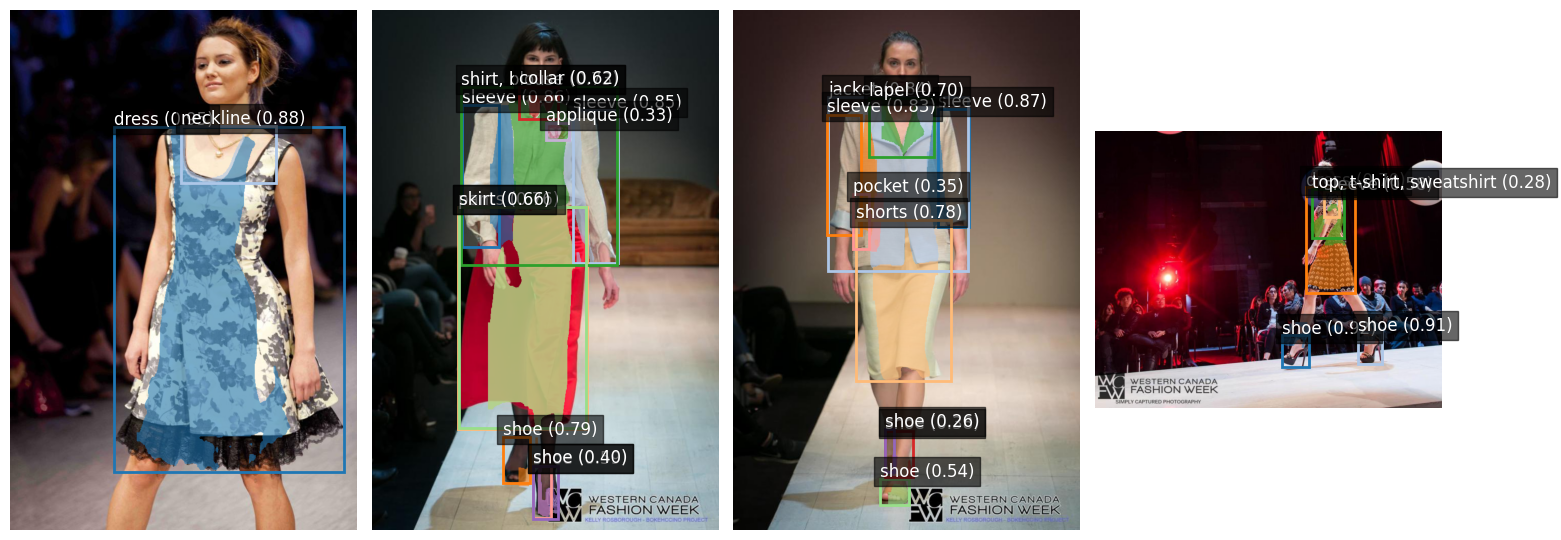

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import matplotlib

# Load the trained YOLOv8 segmentation model
model_eval_visualize = YOLO("runs/segment/train69/weights/best.pt")

# Image paths
image_paths = [
    "datasets/ds_ann/images/val/0046f98599f05fd7233973e430d6d04d.jpg",
    "datasets/ds_ann/images/val/004e9e21cd1aca568a8ffc77a54638ce.jpg",
    "datasets/ds_ann/images/val/00a1940434d687a785be0acf2b0fbff3.jpg",
    "datasets/ds_ann/images/val/01c4698117bd9b3f99bc751da8dfd96c.jpg"
]

# Run inference
results = model_eval_visualize(image_paths)

# Define function to visualize predictions with properly resized masks
def plot_yolo_predictions(results, alpha=0.6):
    """
    Plots YOLOv8 segmentation predictions by applying properly resized masks onto the original image,
    ensuring accurate alignment without altering background pixels.

    Args:
        results: YOLOv8 model predictions (list of Results objects)
        alpha: Transparency factor for blending masks with the original image
    """
    num_results = len(results)
    fig, axes = plt.subplots(1, num_results, figsize=(16, 8))  # Adjust layout based on number of images

    if num_results == 1:
        axes = [axes]  # Ensure iterable if only one image

    for ax, result in zip(axes, results):
        img = result.orig_img  # Original image (numpy array)
        masks = result.masks  # Predicted masks
        boxes = result.boxes  # Bounding boxes
        scores = result.boxes.conf.cpu().numpy() if boxes is not None else []  # Confidence scores
        class_ids = result.boxes.cls.cpu().numpy().astype(int) if boxes is not None else []  # Class IDs
        categories = model_eval_visualize.names  # Class ID to name mapping

        # Convert image to RGB for visualization
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Generate colors for masks
        num_masks = len(masks) if masks is not None else 0
        colors = matplotlib.colormaps["tab20"]

        # Apply segmentation masks properly resized to match the original image size
        if masks is not None:
            for i, mask in enumerate(masks.data.cpu().numpy()):
                color = np.array(colors(i % 20)[:3]) * 255  # Get color and scale to RGB range
                mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)  # Ensure proper resizing
                mask_binary = mask_resized > 0.5  # Convert to binary mask

                # Apply the colored mask only to object areas
                img_rgb[mask_binary] = (alpha * color + (1 - alpha) * img_rgb[mask_binary]).astype(np.uint8)

        # Draw bounding boxes and labels
        if boxes is not None:
            for i, (box, score, cls_id) in enumerate(zip(boxes.xyxy.cpu().numpy(), scores, class_ids)):
                x_min, y_min, x_max, y_max = box
                category_name = categories[cls_id]  # Get class name

                # Draw rectangle for bounding box
                rect = plt.Rectangle(
                    (x_min, y_min), x_max - x_min, y_max - y_min,
                    linewidth=2, edgecolor=colors(i % 20), facecolor="none"
                )
                ax.add_patch(rect)

                # Display label with confidence score
                label = f"{category_name} ({score:.2f})"
                ax.text(x_min, y_min - 5, label, color="white", fontsize=12, 
                        backgroundcolor="black", bbox=dict(facecolor="black", alpha=0.6))

        # Display the modified image
        ax.imshow(img_rgb)
        ax.axis("off")  # Hide axis

    plt.tight_layout()  # Adjust layout
    plt.show()

# Call function to visualize predictions with resized masks
plot_yolo_predictions(results)


Results from running evaluation on another computer

In [ ]:
                Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 
                   all       1158       8495      0.653      0.421      0.446      0.332      0.634      0.394      0.409      0.256
         shirt, blouse        102        102      0.551      0.569      0.558       0.47        0.5       0.48      0.478      0.313
top, t-shirt, sweatshirt        463        477    0.727      0.776      0.795      0.653       0.73      0.744       0.75      0.542
               sweater         21         21      0.358      0.381      0.323      0.299      0.336      0.333      0.294      0.232
              cardigan         12         12      0.193      0.333      0.328      0.264      0.201      0.333      0.243     0.0923
                jacket        179        183      0.721      0.803      0.834      0.768      0.626      0.683      0.676      0.299
                  vest         21         22      0.589      0.364      0.449      0.324      0.455      0.273      0.316      0.185
                 pants        313        314      0.791       0.92      0.946      0.847      0.807       0.92      0.937      0.784
                shorts        106        106      0.667      0.776      0.797       0.67      0.712      0.802      0.817      0.545
                 skirt        162        162      0.583      0.784      0.758      0.692      0.565      0.747      0.688      0.578
                  coat        103        104      0.651      0.798      0.827      0.738      0.643      0.769      0.787      0.437
                 dress        506        508      0.792      0.923      0.943      0.853       0.78      0.896      0.896      0.722
              jumpsuit         21         21      0.419      0.429      0.389      0.318      0.406      0.391      0.384      0.309
                  cape          5          5          1          0      0.164      0.136          1          0      0.158     0.0982
               glasses        130        130       0.81        0.8      0.863      0.595       0.82      0.792      0.853      0.498
                   hat         74         74      0.665       0.77      0.813       0.69      0.683       0.77       0.82      0.577
headband, head covering, hair accessory        105        109      0.538       0.33      0.397      0.233      0.543      0.305      0.367      0.174
                   tie          3          3      0.243      0.667      0.506      0.284      0.247      0.667      0.506      0.303
                 glove         18         31      0.609      0.387      0.386      0.296      0.673      0.387      0.386       0.28
                 watch         82         82      0.619      0.354      0.417      0.205      0.575      0.293      0.383      0.174
                  belt        159        164      0.535      0.409      0.425      0.259      0.526      0.372      0.393      0.147
            leg warmer          5         10          1          0      0.332      0.216          1          0      0.259      0.218
     tights, stockings         48         94      0.545      0.727      0.615      0.462      0.588      0.723      0.644      0.452
                  sock         50         85      0.542      0.329      0.355      0.202      0.574      0.317      0.351      0.194
                  shoe        711       1380      0.736      0.864       0.86      0.646      0.737      0.849      0.832      0.443
           bag, wallet        203        210      0.542      0.671      0.648      0.413      0.583      0.662      0.629      0.386
                 scarf         48         48      0.523      0.333      0.368      0.208      0.502      0.273       0.29      0.144
              umbrella          5          5      0.553        0.8      0.661      0.579      0.568      0.792      0.661      0.578
                  hood         32         32      0.542      0.188      0.334      0.199       0.56      0.188      0.279       0.15
                collar        205        212      0.644      0.505      0.563      0.337      0.597      0.439      0.454      0.169
                 lapel        132        135      0.642      0.622      0.666      0.418      0.643      0.546      0.587       0.26
             epaulette          7         14      0.279      0.357      0.266      0.131      0.295      0.357      0.254       0.11
                sleeve        734       1408      0.823       0.87      0.901      0.662       0.83      0.857      0.882      0.607
                pocket        288        541      0.563      0.268       0.32      0.153      0.544      0.238      0.276      0.122
              neckline        891        919       0.66      0.635      0.675      0.402      0.524      0.468       0.42      0.123
                buckle         64         67      0.522      0.179      0.229      0.104       0.24     0.0746     0.0824      0.023
                zipper        104        192      0.473     0.0365     0.0699     0.0271      0.267     0.0156     0.0213    0.00519
              applique         28         57      0.318     0.0175     0.0392     0.0241      0.366     0.0175     0.0409       0.02
                  bead         33        107      0.452     0.0312     0.0584     0.0301      0.335     0.0187     0.0563      0.037
                   bow          5          6          1          0    0.00625    0.00385          1          0    0.00625    0.00368
                flower          6         37          1          0    0.00487    0.00301          1          0    0.00471    0.00171
                fringe         11         30          1     0.0627      0.157     0.0817          1     0.0608      0.157     0.0735
                ribbon          5          7          1          0    0.00159    0.00138          1          0    0.00334    0.00126
                 rivet         55        143          1          0     0.0233     0.0144          1          0     0.0187    0.00767
                ruffle         59         76       0.62      0.279      0.275      0.207        0.6       0.25       0.28      0.188
                sequin          7         13          1          0       0.18      0.154          1          0      0.179      0.149
                tassel          7         37          1          0          0          0          1          0          0          0

# DeepLabV3+

#### Functions & datasets

In [ ]:
class MetricsLogger:
    def __init__(self):
        self.losses = []  # Store the losses for each batch
        self.batch_loss = [] # Store the loss for each batch
        # self.total_loss = 0.0  # Total loss for the epoch

    def log(self, loss):
        """Logs the loss for each batch."""
        self.losses.append(loss)
        # self.total_loss += loss
        # self.batch_count += 1
    def log_batch_loss(self, loss):
        self.batch_loss.append(loss)
        
    def get_batch_loss(self):
        self.batch_loss = np.array(self.batch_loss)
        return np.mean(self.batch_loss)
        
    def get_avg_loss(self):
        """Returns the average loss for the epoch."""
        self.losses = np.array(self.losses)
        return np.mean(self.losses) 

    def reset(self):
        """Resets the accumulated metrics for a new epoch."""
        self.losses = []
        
    def reset_loss_batch(self):
        self.batch_loss = []

In [5]:
from torch.utils.data import Dataset, DataLoader

class FashionpediaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, image_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform = transform
        self.image_size = image_size  # Specify desired image size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        
        
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_name = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.png'))

        # Load image and mask
        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name)

        # Resize both the image and mask to the target size
        image = image.resize(self.image_size)
        mask = mask.resize(self.image_size, Image.NEAREST)  # Use nearest neighbor for mask resizing

        # Convert mask to tensor
        mask = np.array(mask)
        mask = torch.tensor(mask, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, mask


#### Training Loop


In [ ]:
from tqdm import tqdm
import torch
import os
from PIL import Image
import torch.nn.functional as F
import os
import numpy as np
import json


def safe_nanmean(values):
    return np.nanmean([v for v in values if v is not None])

def train(model, train_loader, val_loader, dir, model_name, loss_fn, patience, optimizer=None, num_epochs=None, epoch=0, resume=False, num_classes=14,val=True, dir_model="./fashionpedia/annotations/val/updated_instances_attributes_val2020.json"):
    train_loss = {}
    val_loss_dict = {}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if resume:
        checkpoint = torch.load(os.path.join(dir, model_name+".pth"))
        epoch = checkpoint['epoch'] + 1
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_miou = checkpoint.get('best_miou', 0.0)
        train_loss = checkpoint.get('train_loss', {})
        val_loss_dict = checkpoint.get('val_loss', {})
        epochs_without_improvement = 0  # optional to restore if saved
        num_epochs_saved = checkpoint['total_epochs']
        num_epochs = num_epochs_saved if num_epochs is None else num_epochs
        model_name = model_name.replace("_last", "")
    else:
        best_miou = 0.0
        epochs_without_improvement = 0
    
    for epoch in range(epoch, num_epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Training Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, (images, masks) in pbar:
            
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 10 == 0 or batch_idx == len(train_loader) - 1:
                pbar.set_postfix({"Loss": f"{running_loss / (batch_idx + 1):.4f}"})

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
        train_loss[epoch+1] = (running_loss / len(train_loader))
        
        os.makedirs(dir, exist_ok=True)
        torch.save({
            "epoch": epoch,
            "total_epochs": num_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_miou": best_miou,
            "train_loss": train_loss,
            }, os.path.join(dir, f"{model_name}_last"+".pth"))
        
        # ---- VALIDATION ---- #
        if val:
            
            with open(dir_model, "r") as f:
                ann_ = json.load(f)
            cat_map = {0: "background"}
            for cat in ann_['categories']:
                cat_map[cat['id']] = cat['name']
            num_classes = len(cat_map)
            
            total_tp = {cls: 0 for cls in range(num_classes)}
            total_fp = {cls: 0 for cls in range(num_classes)}
            total_fn = {cls: 0 for cls in range(num_classes)}
            total_iou_sum = {cls: 0.0 for cls in range(num_classes)}
            total_iou_count = {cls: 0 for cls in range(num_classes)}

            all_tp = 0
            # all_fp = 0
            # all_fn = 0
            # all_iou_sum = 0
            # all_iou_count = 0
            total_pixels = 0
            val_running_loss = 0.0

            with torch.no_grad():
                model.eval()
                val_pbar = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Validating Epoch {epoch+1}/{num_epochs}")
                for batch_idx, (images, gt_mask) in val_pbar:
                    
                    
                    images_rgb, gt_mask = images.to(device), gt_mask.to(device)
                    total_pixels += np.prod(gt_mask.shape)  # Total number of pixels in the batch
                    
                    pred_mask = model(images_rgb)
                    
                    val_loss = loss_fn(pred_mask, gt_mask)
                    val_running_loss += val_loss.item()
                    
                    probs = F.softmax(pred_mask, dim=1)
                    pred_mask = torch.argmax(probs, dim=1).cpu().numpy()
                    
                    gt_mask = gt_mask.cpu().numpy()
                    
                    tp_tmp = np.sum(gt_mask == pred_mask)
                    all_tp += tp_tmp
 

                    present_classes = set(np.unique(gt_mask)) | set(np.unique(pred_mask))
                    for cls in present_classes:  # Only store metrics for present classes
                        
                        gt = (gt_mask == cls)
                        pred = (pred_mask == cls)
                        
                        tp = np.logical_and(gt, pred).sum()
                        fp = np.logical_and(np.logical_not(gt), pred).sum()
                        fn = np.logical_and(gt, np.logical_not(pred)).sum()
                        
                        total_tp[cls] += tp
                        total_fp[cls] += fp
                        total_fn[cls] += fn

                        # For IoU averaging
                        union = np.logical_or(gt, pred).sum()
                        if union > 0:
                            iou = tp / union
                            total_iou_sum[cls] += iou
                            total_iou_count[cls] += 1
                            
                final_precision_by_class = {}
                final_recall_by_class = {}
                final_f1_by_class = {}
                final_iou_by_class = {}

                for cls in range(num_classes):
                    tp = total_tp[cls]
                    fp = total_fp[cls]
                    fn = total_fn[cls]

                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
                    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
                    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
                    iou = total_iou_sum[cls] / total_iou_count[cls] if total_iou_count[cls] > 0 else 0.0

                    final_precision_by_class[cat_map[cls]] = precision
                    final_recall_by_class[cat_map[cls]] = recall
                    final_f1_by_class[cat_map[cls]] = f1
                    final_iou_by_class[cat_map[cls]] = iou
                
                # Filter out None values before applying np.nanmean
                def safe_nanmean(values):
                    # Remove None values and use np.nanmean on the remaining values
                    return np.nanmean([v for v in values if v is not None])

                print(f"[Validation] Loss: {val_running_loss / len(val_loader):.4f} | "
                f"Avg Precision: {safe_nanmean(list(final_precision_by_class.values())):.4f} | "
                f"Avg Recall: {safe_nanmean(list(final_recall_by_class.values())):.4f} | "
                f"Avg F1: {safe_nanmean(list(final_f1_by_class.values())):.4f} | "
                f"mIoU: {safe_nanmean(list(final_iou_by_class.values())):.4f} |"
                f"Pixel Accuracy: {all_tp / total_pixels if total_pixels > 0 else 0:.4f} | "
                )
                
                val_loss_dict[epoch+1] = (val_running_loss / len(val_loader))
                os.makedirs(dir, exist_ok=True)
                torch.save({
                    "epoch": epoch,
                    "total_epochs": num_epochs,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_miou": best_miou,
                    "train_loss": train_loss,
                    "val_loss": val_loss_dict
                }, os.path.join(dir, f"{model_name}_last"+".pth"))

                
                miou = safe_nanmean(list(final_iou_by_class.values()))  # early stop target metric

                # ---- EARLY STOPPING LOGIC ---- #
                if miou > best_miou:
                    print(f"Validation mIoU improved from {best_miou:.4f} to {miou:.4f}. Saving model...")
                    best_miou = miou
                    epochs_without_improvement = 0

                    os.makedirs(dir, exist_ok=True)
                    torch.save({
                        "epoch": epoch,
                        "total_epochs": num_epochs,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "best_miou": best_miou,
                        "train_loss": train_loss,
                        "val_loss": val_loss_dict
                    }, os.path.join(dir, f"{model_name}_best"+".pth"))

                else:
                    epochs_without_improvement += 1
                    print(f"No improvement in mIoU. ({epochs_without_improvement}/{patience})")

                if epochs_without_improvement >= patience:
                    print(f"Early stopping triggered after {patience} epochs with no improvement.")
                    break

### Visualizing

image ids with category vest
15069, 14915, 16478

cardigan:
17312,16537,19633
coat: 
19795,19873,19875, 20712


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random
import os
from PIL import Image
import segmentation_models_pytorch as smp
from pycocotools.coco import COCO
from pycocotools import mask
from torch.utils.data import Dataset, DataLoader

class FashionpediaDataset_val(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, image_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform = transform
        self.image_size = image_size  # Specify desired image size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        
        
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_name = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.png'))
        import json
        
        
        with open("fashionpedia/annotations/val/updated_instances_attributes_val2020.json") as f:
            annotations = json.load(f)
        image_id = [i['id'] for i in annotations['images'] if i['file_name'] == self.image_filenames[idx]][0]
        # Load image and mask
        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name)

        # Resize both the image and mask to the target size
        image = image.resize(self.image_size)
        mask = mask.resize(self.image_size, Image.NEAREST)  # Use nearest neighbor for mask resizing

        # Convert mask to tensor
        mask = np.array(mask)
        mask = torch.tensor(mask, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, mask, image_id

def custom_collate_fn(batch):
    """
    Custom collate function to handle batching of image, mask, and metadata.
    
    Args:
        batch (list of tuples): List of tuples from the dataset.
        
    Returns:
        Tuple: Batched images, masks, and metadata.
    """
    images, masks, metadata = zip(*batch)  # Separate images, masks, and metadata
    
    # Stack images and masks into batches
    images = torch.stack(images, dim=0)
    masks = torch.stack(masks, dim=0)

    # Return images, masks, and metadata
    return images, masks, list(metadata)  # Keep metadata as int

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")



modeldeeplabv3plus_eval = smp.DeepLabV3Plus(
    encoder_name="resnet101",        # ResNet101 as the encoder
    encoder_weights="imagenet",    # Use pre-trained weights
    classes=47                    # Number of classes in Fashionpedia +1 for background clas
    # activation="softmax"           # For multi-class segmentation
).to(device)

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    # transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ToTensor(),  # Convert to tensor
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize (for images only)
])

# modeldeeplabv3plus_eval.load_state_dict(torch.load("fashionpedia_deeplabv3plus_resnet101_10ep_march23_2025.pth"))
checkpoint =torch.load("./fine_tuned_models/fashionpedia/deeplabv3plus/fashionpedia_deeplabv3plus_100ep.pt")
modeldeeplabv3plus_eval.load_state_dict(checkpoint['model_state_dict'])
# Switch the model to evaluation mode
modeldeeplabv3plus_eval.eval()

val_dataset_deeplab = FashionpediaDataset_val('fashionpedia/images/val', 'fashionpedia/coco2mask/val', transform=transform)
val_loader_deeplab = DataLoader(val_dataset_deeplab, shuffle=False, collate_fn=custom_collate_fn)

# Load the Fashionpedia category names
annotations = COCO("fashionpedia/annotations/val/updated_instances_attributes_val2020.json")

# Get the category IDs


fashionpedia_classes = [
    "background",
    *[y['name'] for i, y in annotations.cats.items()]
]

import matplotlib.colors as mcolors
import scipy.ndimage

# Define a fixed color palette for 47 classes (including background as class 0)
fixed_color_palette = [
(0,0,0),   
(255, 0, 0),  
(0, 255, 0),   
(0, 0, 255),   
(255, 255, 0),   
(255, 0, 255),   
(0, 255, 255),   
(128, 0, 0),   
(0, 128, 0),   
(0, 0, 128),   
(128, 128, 0),   
(128, 0, 128),   
(0, 128, 128),   
(192, 192, 192),   
(128, 128, 128),   
(255, 165, 0),   
(255, 20, 147),   
(75, 0, 130),   
(255, 105, 180),   
(139, 69, 19),   
(240, 230, 140),   
(173, 216, 230),   
(124, 252, 0),   
(32, 178, 170),   
(135, 206, 250),   
(72, 61, 139),   
(0, 191, 255),   
(255, 69, 0),   
(154, 205, 50),   
(47, 139, 87),   
(255, 215, 0),   
(199, 21, 133),   
(0, 100, 0),   
(85, 107, 47),   
(218, 165, 32),   
(100, 149, 237),   
(220, 20, 60),   
(186, 85, 211),   
(107, 142, 35),   
(0, 250, 154),   
(148, 0, 211),   
(60, 179, 113),   
(255, 140, 0),   
(138, 43, 226),   
(255, 182, 193),   
(144, 238, 144),   
(255, 228, 181)   
]


import scipy.ndimage

def apply_fixed_color_map_with_labels(mask, category_names, num_classes=47):
    """Apply a fixed color map to the predicted segmentation mask and return class label mapping, ignoring background."""
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)  # Initialize a blank (black) image
    label_map = np.full(mask.shape, -1, dtype=int)  # Initialize label map with -1 for no labels
    class_labels = []  # Store unique class labels
    centroids = {}  # Store centroids for each class

    for class_id in range(1, num_classes): # eliminate background class  
        if class_id in mask:
            colored_mask[mask == class_id] = fixed_color_palette[class_id]  # Apply fixed color for this class
            label_map[mask == class_id] = class_id
            class_labels.append(category_names[class_id])

            # Find connected regions for the class mask
            class_mask = (mask == class_id)
            labeled_array, num_features = scipy.ndimage.label(class_mask)
            
            # Calculate the area of each region and find the largest region
            areas = np.bincount(labeled_array.ravel())[1:]  # Ignore background
            if len(areas) > 0:
                largest_region = np.argmax(areas) + 1  # Find the label of the largest region (1-based index)

                # Calculate the centroid of the largest region
                centroid = scipy.ndimage.center_of_mass(class_mask, labeled_array, largest_region)
                if centroid:
                    centroids[class_id] = centroid  # Store the centroid for this class

    return colored_mask, label_map, class_labels, centroids

# Updated function to visualize with labels at the largest area
def visualize_predictions_for_specific_ids(model, data_loader, category_names, device, image_ids_to_plot, num_samples=3):
    """Visualize model predictions on Fashionpedia images with class labels placed on largest regions for specific image IDs."""
    model.eval()  # Set model to evaluation mode
    samples_shown = 0

    for images, masks, image_ids in data_loader:
        # Check if any of the image_ids in the batch match the specified image_ids_to_plot
        indices_to_plot = [i for i, img_id in enumerate(image_ids) if img_id in image_ids_to_plot]

        # Skip this batch if no images match
        if len(indices_to_plot) == 0:
            continue
        
        # Process only the images that match the specified image IDs
        images = images[indices_to_plot].to(device)
        masks = [masks[i] for i in indices_to_plot]
        image_ids = [image_ids[i] for i in indices_to_plot]

        with torch.no_grad():
            outputs = model(images)  # Get model predictions
        
        outputs = torch.nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Plot images, ground truth, and predictions with class labels
        for i in range(len(images)):
            if samples_shown >= num_samples:
                break  # Stop after displaying the required number of images

            image = images[i].cpu().permute(1, 2, 0).numpy()  # Convert tensor image to NumPy format
            mask = masks[i].cpu().numpy()  # Ground truth mask
            pred_mask = preds[i]  # Predicted mask

            # Apply color maps to masks and get corresponding class labels and centroids
            gt_colored, _, gt_labels, gt_centroids = apply_fixed_color_map_with_labels(mask, category_names)
            pred_colored, _, pred_labels, pred_centroids = apply_fixed_color_map_with_labels(pred_mask, category_names)

            # Create a figure with three subplots
            fig, ax = plt.subplots(1, 3, figsize=(12, 5))

            ax[0].imshow(image)
            ax[0].set_title(f"Original Image (ID: {image_ids[i]})")
            ax[0].axis("off")

            ax[1].imshow(gt_colored)
            ax[1].set_title("Ground Truth Mask:\n" + '\n'.join(['-'.join(gt_labels[i:i+5]) for i in range(0, len(gt_labels), 5)]), fontsize=10)
            ax[1].axis("off")

            # Plot the labels at the centroids of the largest regions for ground truth (ignoring background)
            for class_id, centroid in gt_centroids.items():
                y, x = int(centroid[0]), int(centroid[1])
                ax[1].text(x, y, category_names[class_id], color='white', fontsize=8, ha='center', va='center')

            ax[2].imshow(image)
            ax[2].imshow(pred_colored, alpha=0.5)  # Overlay with transparency
            ax[2].set_title("Predicted Mask:\n" + '\n'.join(['-'.join(pred_labels[i:i+5]) for i in range(0, len(pred_labels), 5)]),fontsize=10)
            ax[2].axis("off")

            # Plot the labels at the centroids of the largest regions for predictions (ignoring background)
            for class_id, centroid in pred_centroids.items():
                y, x = int(centroid[0]), int(centroid[1])
                ax[2].text(x, y, category_names[class_id], color='white', fontsize=8, ha='center', va='center')

            plt.show()
            samples_shown += 1

            if samples_shown >= num_samples:
                break  # Stop after displaying the required number of images


/tmp/ipykernel_1683/2575059961.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint =torch.load("./fine_tuned_models/fashionpedia/deeplabv3plus/fashionpedia_deepl

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


task: visualize these

#### "shirt, blouse" visualizing

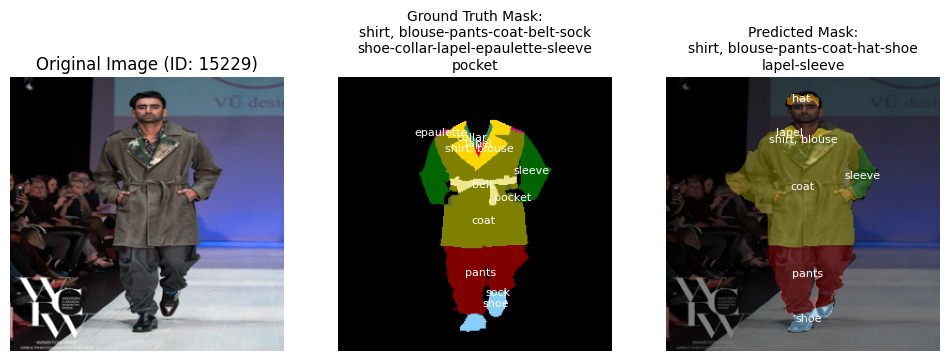

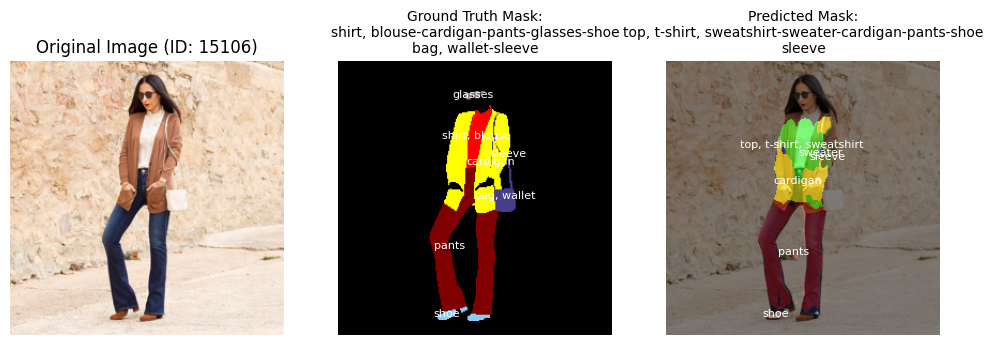

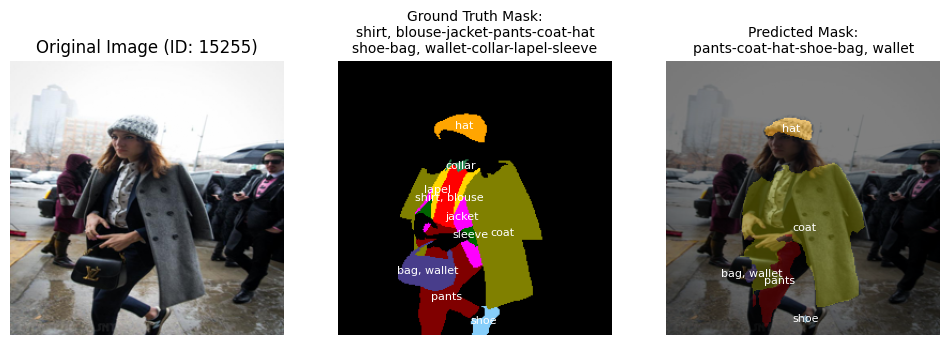

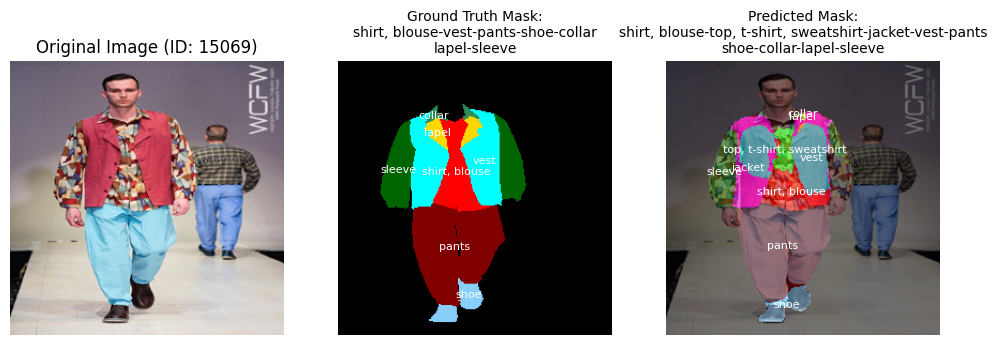

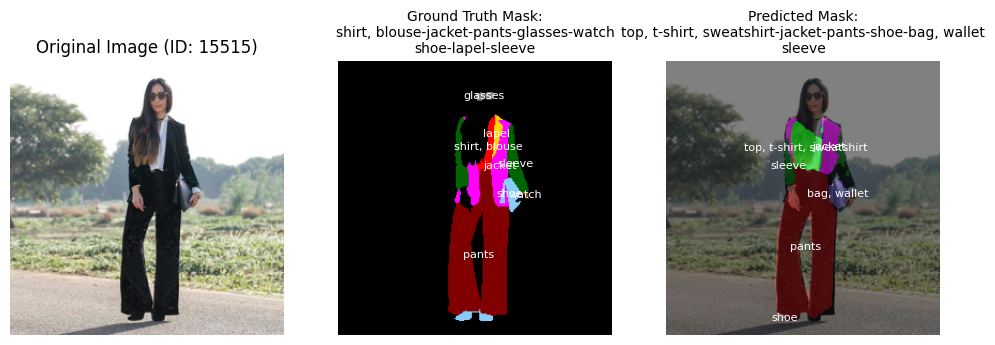

In [13]:
# Specify the image IDs you want to plot
image_ids_to_plot = [15069, 15106, 15229, 15255, 15515]

# Call the updated function to visualize specific image IDs with labels on the mask edges
visualize_predictions_for_specific_ids(modeldeeplabv3plus_eval, val_loader_deeplab, fashionpedia_classes, device, image_ids_to_plot, num_samples=5)

In [128]:
checkpoint['epoch']

39

after training 40 epochs

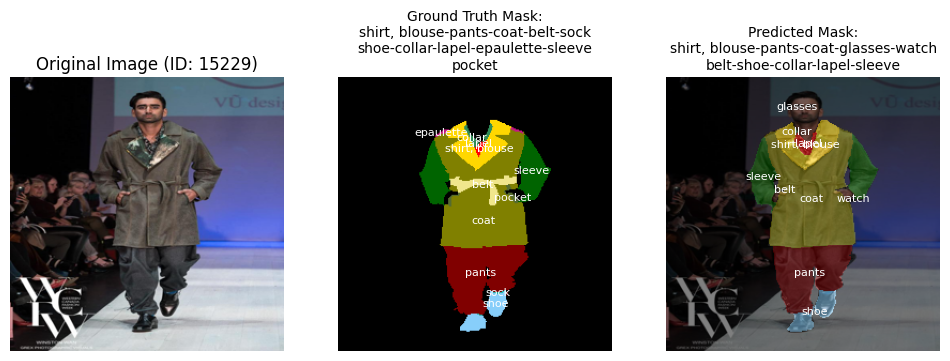

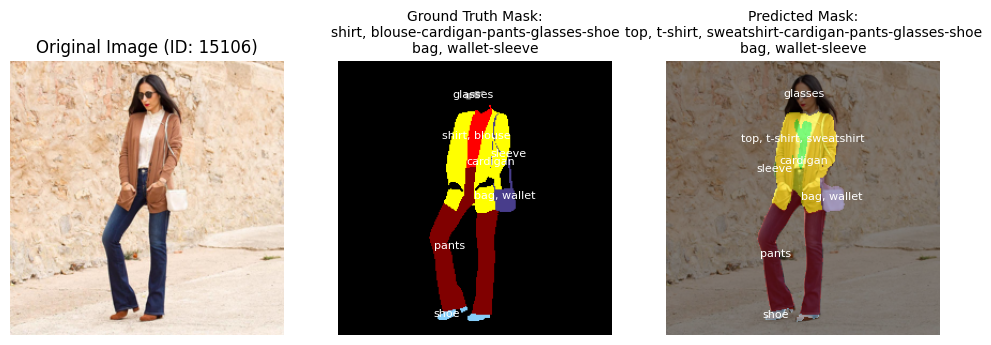

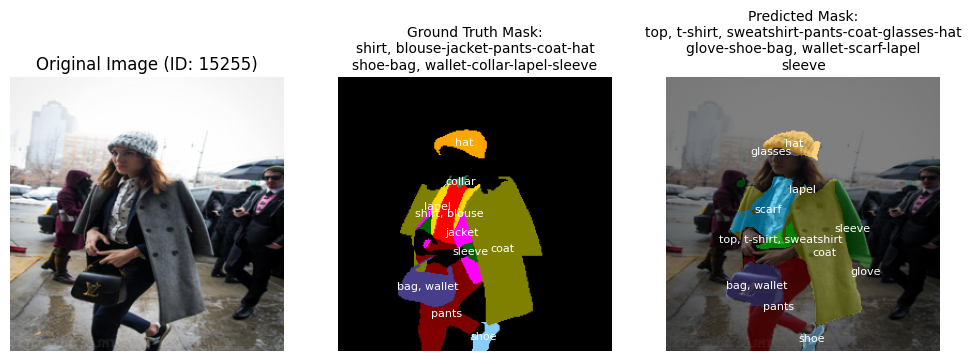

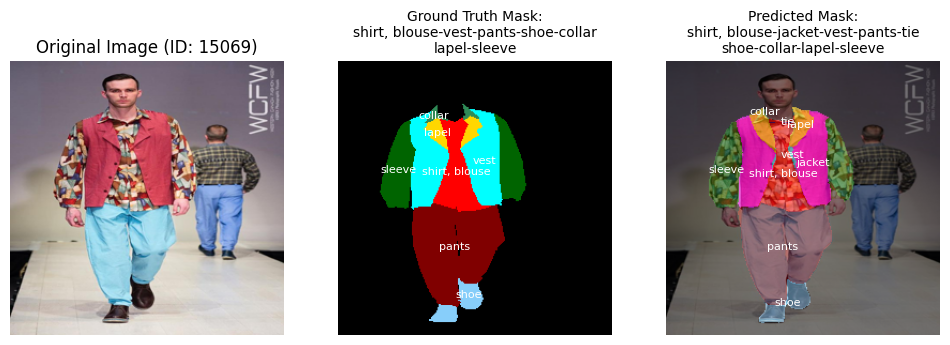

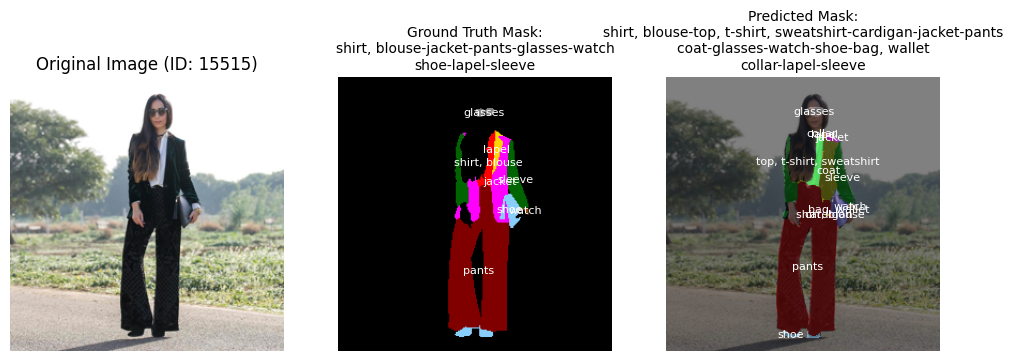

In [129]:
# Specify the image IDs you want to plot

image_ids_to_plot = [15069, 15106, 15229, 15255, 15515]

# Call the updated function to visualize specific image IDs with labels on the mask edges
visualize_predictions_for_specific_ids(modeldeeplabv3plus_eval, val_loader_deeplab, fashionpedia_classes, device, image_ids_to_plot, num_samples=5)

#### Coat visualizing

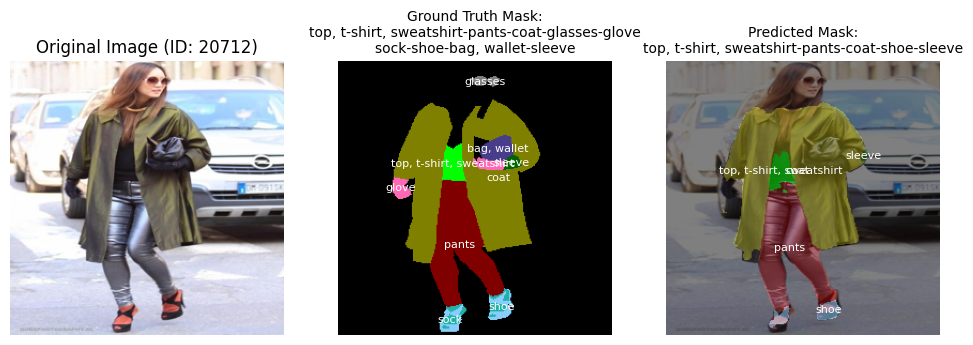

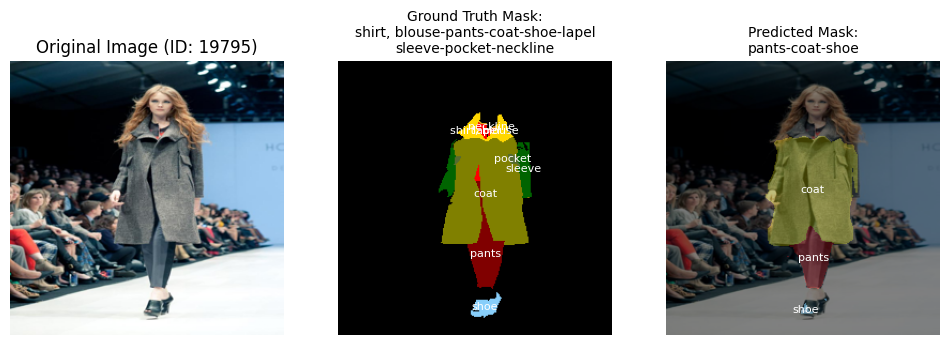

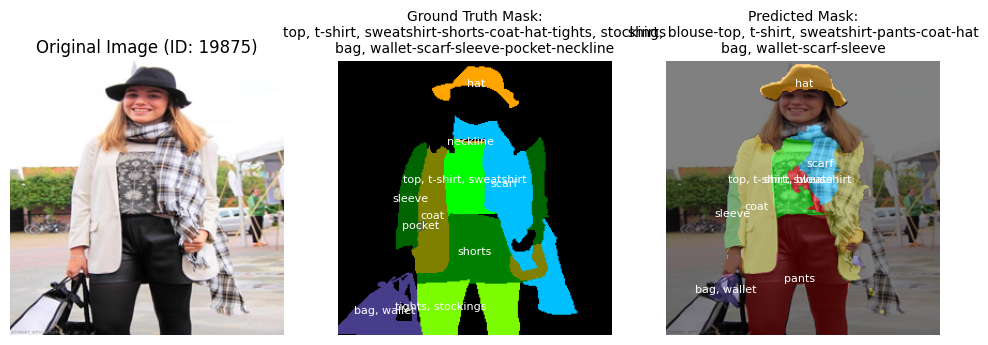

In [14]:
# Specify the image IDs you want to plot
image_ids_to_plot = [19795, 19875, 20712]

# Call the updated function to visualize specific image IDs with labels on the mask edges
visualize_predictions_for_specific_ids(modeldeeplabv3plus_eval, val_loader_deeplab, fashionpedia_classes, device, image_ids_to_plot, num_samples=3)

#### Vest visualizing

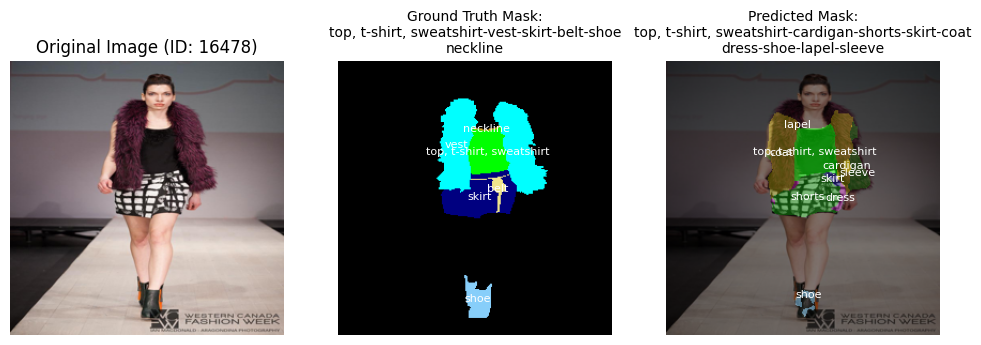

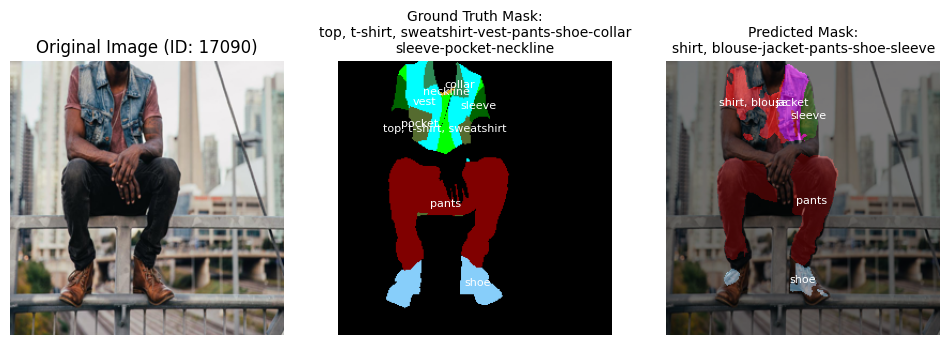

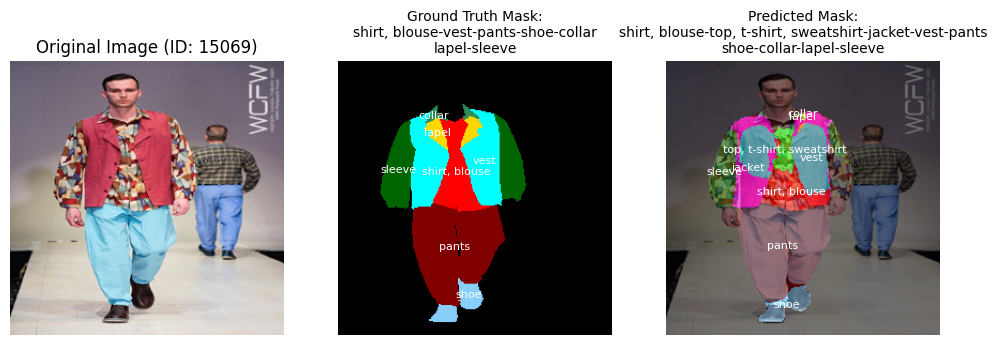

In [15]:
# Specify the image IDs you want to plot
image_ids_to_plot = [15069, 17090, 16478]

# Call the updated function to visualize specific image IDs with labels on the mask edges
visualize_predictions_for_specific_ids(modeldeeplabv3plus_eval, val_loader_deeplab, fashionpedia_classes, device, image_ids_to_plot, num_samples=3)

#### Cardigan visualizing


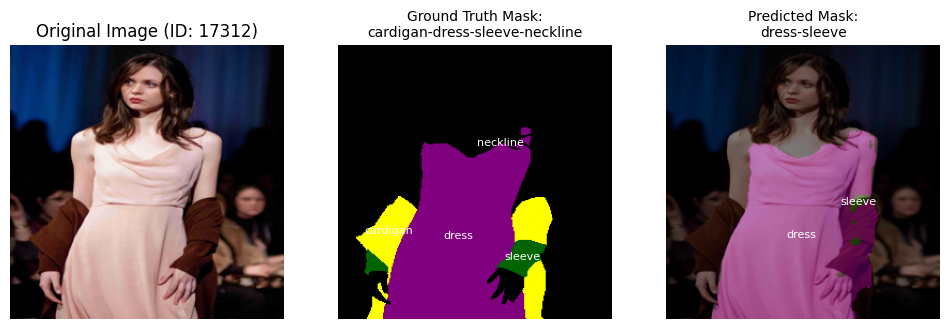

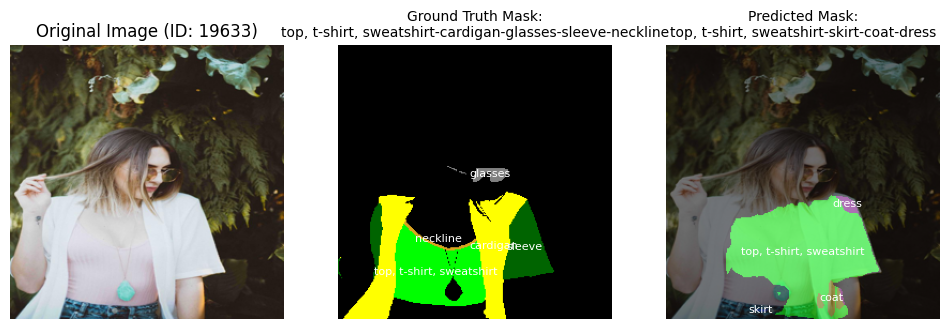

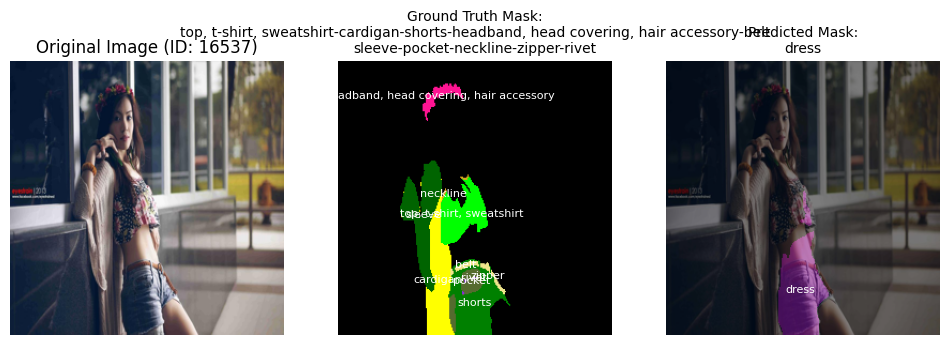

In [17]:
# Specify the image IDs you want to plot
image_ids_to_plot = [17312,16537,19633]

# Call the updated function to visualize specific image IDs with labels on the mask edges
visualize_predictions_for_specific_ids(modeldeeplabv3plus_eval, val_loader_deeplab, fashionpedia_classes, device, image_ids_to_plot, num_samples=3)

## COCO eval

In [ ]:

import json
from pycocotools import mask
import numpy as np
import segmentation_models_pytorch as smp

from torchvision import transforms
import torch
from PIL import Image
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader


from torchvision import transforms
import torch
from PIL import Image
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import label

class FashionpediaDatasetDeepLab_val(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, image_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform = transform
        self.image_size = image_size  # Specify desired image size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        
        
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_name = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.png'))
        import json
        
        
        with open("fashionpedia/annotations/val/updated_instances_attributes_val2020.json") as f:
            annotations = json.load(f)
        image_id = [i['id'] for i in annotations['images'] if i['file_name'] == self.image_filenames[idx]][0]
        # Load image and mask
        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name)

        # Resize both the image and mask to the target size
        image = image.resize(self.image_size)
        mask = mask.resize(self.image_size, Image.NEAREST)  # Use nearest neighbor for mask resizing

        # Convert mask to tensor
        mask = np.array(mask)
        mask = torch.tensor(mask, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, mask, image_id
    
    
def custom_collate_fn(batch):
    """
    Custom collate function to handle batching of image, mask, and metadata.
    
    Args:
        batch (list of tuples): List of tuples from the dataset.
        
    Returns:
        Tuple: Batched images, masks, and metadata.
    """
    images, masks, metadata = zip(*batch)  # Separate images, masks, and metadata
    
    # Stack images and masks into batches
    images = torch.stack(images, dim=0)
    masks = torch.stack(masks, dim=0)

    # Return images, masks, and metadata
    return images, masks, list(metadata)  # Keep metadata as int

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")


modeldeeplabv3plus = smp.DeepLabV3Plus(
    encoder_name="resnet101",        # ResNet101 as the encoder
    encoder_weights="imagenet",    # Use pre-trained weights
    classes=47,                    # Number of classes in Fashionpedia +1 for background clas
    # activation="softmax"           # For multi-class segmentation
).to(device)

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    # transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ToTensor(),  # Convert to tensor
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize (for images only)
])

# modeldeeplabv3plus.load_state_dict(torch.load("fashionpedia_deeplabv3plus_resnet101_1ep.pth"))
checkpoint = torch.load("./fine_tuned_models/fashionpedia/deeplabv3plus/fashionpedia_deeplabv3plus_resnet101_200ep_256_last.pth")
# Load the model architecture
modeldeeplabv3plus.load_state_dict(checkpoint['model_state_dict'])
# Switch the model to evaluation mode
modeldeeplabv3plus.eval()

val_dataset_deeplab = FashionpediaDatasetDeepLab_val('fashionpedia/images/val', 'fashionpedia/masks/val', transform=transform)
val_loader_deeplab = DataLoader(val_dataset_deeplab, batch_size=6, shuffle=False, collate_fn=custom_collate_fn)
def create_fashionpedia_predictions(model, val_loader, device, save_path):
    """
    Generate Fashionpedia-compatible predictions from the model.
    
    Args:
        model: Trained segmentation model.
        test_loader: DataLoader for the test dataset.
        device: Device to run the model on (CPU or GPU).
        save_path: File path to save predictions in COCO JSON format.
    
    Returns:
        None
    """

    model.eval()
    predictions = []

    with torch.no_grad():
        for image_id, (images, masks, img_idx) in enumerate(val_loader):
            images = images.to(device)
            pred_masks = model(images)  # Output: (batch_size, num_classes, H, W)
            # ----
            # did this feb 6 2025
            pred_probs = torch.softmax(pred_masks, dim=1)  # Convert logits to probabilities
            # pred_probs = pred_masks  # Convert logits to probabilities
            # ----
            pred_classes = torch.argmax(pred_probs, dim=1)  # Predicted class per pixel
            for i in range(images.size(0)):  # Iterate over the batch
                img_id = img_idx[i]
                single_pred_mask = pred_classes[i].cpu().numpy()  # Single image prediction
                single_pred_probs = pred_probs[i].cpu().numpy()  # Single image probabilities

                for class_id in np.unique(single_pred_mask):
                    if class_id == 0:
                        continue
                    binary_mask = (single_pred_mask == class_id).astype(np.uint8)
                    if binary_mask.sum() < 20:  # skip tiny regions
                        continue
                    
                    # Convert mask to RLE
                    rle = mask.encode(np.asfortranarray(binary_mask))
                    rle["counts"] = rle["counts"].decode("utf-8")  # Ensure JSON serializability
                    
                    # Confidence score: maximum probability of the class
                    confidence_score = single_pred_probs[class_id].max()
                    
                    predictions.append({
                        "image_id": int(img_id),  # Matches ID in the ground truth
                        "category_id": int(class_id),
                        # "segmentation": binary_mask,
                        "segmentation": rle,
                        "attribute_ids": [],
                        "score": float(confidence_score)
                    })
    
    # Save predictions to JSON
    with open(save_path, "w") as f:
        json.dump(predictions, f)
        
create_fashionpedia_predictions(modeldeeplabv3plus, val_loader_deeplab, device, save_path="fashionpedia_predictions.json")


/tmp/ipykernel_1683/740792099.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./fine_tuned_models/fashionpedia/deeplabv3plus/fashionpedia_deep

In [125]:
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO


# Load ground truth and predictions
coco_gt = COCO("./fashionpedia/annotations/val/updated_instances_attributes_val2020.json")
coco_dt = coco_gt.loadRes("fashionpedia_predictions.json")

# # Initialize COCOeval
coco_eval = COCOeval(coco_gt, coco_dt, iouType="segm")  # or "bbox" for bounding boxes
# print(coco_gt.getAnnIds())

# coco_eval.params.catIds


# # Run evaluation
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=1.53s).
Accumulating evaluation results...
DONE (t=0.35s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [2]:
import json 

with open("fashionpedia_predictions.json", "r") as f:
    annotations = json.load(f)
annotations

[{'image_id': 11572,
  'category_id': 7,
  'segmentation': {'size': [256, 256], 'counts': 'fnT12l72N3OO1O0Ldai0'},
  'score': 0.47623106837272644,
  'attribute_ids': []},
 {'image_id': 11572,
  'category_id': 7,
  'segmentation': {'size': [256, 256],
   'counts': 'Ugi01o72N4L8H;E1N1O100000000000000000000O10VOPId0P7[ORId0n6\\ORId0m6\\OUIc0k6\\OVId0i6\\OXId0g6\\OZId0f6[O[Ie0d6\\O]Ic0c6\\O^Id0a6\\O`Id0n6000002N1O1O1O1O1O1O4I\\Pl0'},
  'score': 0.8096820116043091,
  'attribute_ids': []},
 {'image_id': 11572,
  'category_id': 11,
  'segmentation': {'size': [256, 256], 'counts': 'UZc01je\\1'},
  'score': 0.4745666980743408,
  'attribute_ids': []},
 {'image_id': 11572,
  'category_id': 11,
  'segmentation': {'size': [256, 256], 'counts': 'YZb04ce]1'},
  'score': 0.42635130882263184,
  'attribute_ids': []},
 {'image_id': 11572,
  'category_id': 11,
  'segmentation': {'size': [256, 256],
   'counts': '[f;4k72N2N1O2N1O2N1M4M2M4M2N2O2N1O1N2O1O2M2O1O1^NjNYLX1a3TOWLm0h3VOULl0h3XOULj0i3XOULk0h3XOULk

## Training Deeplab ->

In [ ]:
import segmentation_models_pytorch as smp


from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    # transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ToTensor(),  # Convert to tensor
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize (for images only)
])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dir_val = "./fashionpedia/images/val/"
dir_mask_val = "./fashionpedia/coco2mask/val/"

# Test DataLoader
val_dataset = FashionpediaDataset(dir_val, dir_mask_val, transform=transform, image_size=(256,256))
# val_loader = DataLoader(val_dataset,batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, shuffle=False)

# Create datasets and dataloaders
train_dataset = FashionpediaDataset('./fashionpedia/images/train/', './fashionpedia/coco2mask/train/', transform=transform, image_size=(256,256))
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2)

logger = MetricsLogger()

num_classes = 47  # 46 classes + 1 background 
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256 recommended by deeplab
    transforms.ToTensor(),
])

# Initialize DeepLabV3+ model with ResNet101 encoder
modeldeeplabv3plus = smp.DeepLabV3Plus(
    encoder_name="resnet101",        # ResNet101 as the encoder
    encoder_weights="imagenet",    # Use pre-trained weights
    classes=num_classes,                    # Number of classes in Fashionpedia +1 for background clas
)

modeldeeplabv3plus.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modeldeeplabv3plus.parameters(), lr=1e-4)

num_epochs = 100
train(model=modeldeeplabv3plus, train_loader=train_loader, optimizer=optimizer, loss_fn=loss_fn,
      dir="./fine_tuned_models/fashionpedia/deeplabv3plus", model_name="fashionpedia_deeplabv3plus_resnet101_200ep_256", num_classes=47, 
      val_loader=val_loader, val=True, patience=5, num_epochs=num_epochs)

Training Epoch 1/100: 100%|██████████| 7604/7604 [15:13<00:00,  8.33it/s, Loss=0.4315]


Epoch [1/100], Loss: 0.4315


Validating Epoch 1/100: 100%|██████████| 1158/1158 [00:39<00:00, 29.46it/s]


[Validation] Loss: 0.2537 | Avg Precision: 0.2253 | Avg Recall: 0.1586 | Avg F1: 0.1664 | mIoU: 0.0848 |Pixel Accuracy: 0.9262 | 
Validation mIoU improved from 0.0000 to 0.0848. Saving model...


Training Epoch 2/100: 100%|██████████| 7604/7604 [15:21<00:00,  8.25it/s, Loss=0.2919]


Epoch [2/100], Loss: 0.2919


Validating Epoch 2/100: 100%|██████████| 1158/1158 [00:38<00:00, 29.71it/s]


[Validation] Loss: 0.2243 | Avg Precision: 0.2959 | Avg Recall: 0.1839 | Avg F1: 0.2019 | mIoU: 0.0984 |Pixel Accuracy: 0.9334 | 
Validation mIoU improved from 0.0848 to 0.0984. Saving model...


Training Epoch 3/100: 100%|██████████| 7604/7604 [15:40<00:00,  8.08it/s, Loss=0.2553]


Epoch [3/100], Loss: 0.2553


Validating Epoch 3/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.34it/s]


[Validation] Loss: 0.2163 | Avg Precision: 0.3650 | Avg Recall: 0.2074 | Avg F1: 0.2237 | mIoU: 0.1118 |Pixel Accuracy: 0.9361 | 
Validation mIoU improved from 0.0984 to 0.1118. Saving model...


Training Epoch 4/100: 100%|██████████| 7604/7604 [15:29<00:00,  8.18it/s, Loss=0.2297]


Epoch [4/100], Loss: 0.2297


Validating Epoch 4/100: 100%|██████████| 1158/1158 [00:36<00:00, 31.92it/s]


[Validation] Loss: 0.2045 | Avg Precision: 0.3490 | Avg Recall: 0.2262 | Avg F1: 0.2476 | mIoU: 0.1239 |Pixel Accuracy: 0.9397 | 
Validation mIoU improved from 0.1118 to 0.1239. Saving model...


Training Epoch 5/100: 100%|██████████| 7604/7604 [14:58<00:00,  8.46it/s, Loss=0.2093]


Epoch [5/100], Loss: 0.2093


Validating Epoch 5/100: 100%|██████████| 1158/1158 [00:37<00:00, 30.86it/s]


[Validation] Loss: 0.2034 | Avg Precision: 0.3911 | Avg Recall: 0.2227 | Avg F1: 0.2500 | mIoU: 0.1217 |Pixel Accuracy: 0.9379 | 
No improvement in mIoU. (1/5)


Training Epoch 6/100: 100%|██████████| 7604/7604 [14:48<00:00,  8.55it/s, Loss=0.1920]


Epoch [6/100], Loss: 0.1920


Validating Epoch 6/100: 100%|██████████| 1158/1158 [00:37<00:00, 30.47it/s]


[Validation] Loss: 0.1984 | Avg Precision: 0.3778 | Avg Recall: 0.2484 | Avg F1: 0.2678 | mIoU: 0.1293 |Pixel Accuracy: 0.9397 | 
Validation mIoU improved from 0.1239 to 0.1293. Saving model...


Training Epoch 7/100: 100%|██████████| 7604/7604 [14:50<00:00,  8.53it/s, Loss=0.1782]


Epoch [7/100], Loss: 0.1782


Validating Epoch 7/100: 100%|██████████| 1158/1158 [00:37<00:00, 31.12it/s]


[Validation] Loss: 0.2035 | Avg Precision: 0.4363 | Avg Recall: 0.2424 | Avg F1: 0.2716 | mIoU: 0.1347 |Pixel Accuracy: 0.9410 | 
Validation mIoU improved from 0.1293 to 0.1347. Saving model...


Training Epoch 8/100: 100%|██████████| 7604/7604 [14:50<00:00,  8.54it/s, Loss=0.1673]


Epoch [8/100], Loss: 0.1673


Validating Epoch 8/100: 100%|██████████| 1158/1158 [00:36<00:00, 31.46it/s]


[Validation] Loss: 0.2048 | Avg Precision: 0.4166 | Avg Recall: 0.2737 | Avg F1: 0.2861 | mIoU: 0.1367 |Pixel Accuracy: 0.9400 | 
Validation mIoU improved from 0.1347 to 0.1367. Saving model...


Training Epoch 9/100: 100%|██████████| 7604/7604 [14:52<00:00,  8.52it/s, Loss=0.1557]


Epoch [9/100], Loss: 0.1557


Validating Epoch 9/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.19it/s]


[Validation] Loss: 0.2093 | Avg Precision: 0.4181 | Avg Recall: 0.2655 | Avg F1: 0.2869 | mIoU: 0.1362 |Pixel Accuracy: 0.9407 | 
No improvement in mIoU. (1/5)


Training Epoch 10/100: 100%|██████████| 7604/7604 [14:47<00:00,  8.57it/s, Loss=0.1489]


Epoch [10/100], Loss: 0.1489


Validating Epoch 10/100: 100%|██████████| 1158/1158 [00:37<00:00, 30.75it/s]


[Validation] Loss: 0.2045 | Avg Precision: 0.4091 | Avg Recall: 0.2768 | Avg F1: 0.2998 | mIoU: 0.1409 |Pixel Accuracy: 0.9412 | 
Validation mIoU improved from 0.1367 to 0.1409. Saving model...


Training Epoch 11/100: 100%|██████████| 7604/7604 [14:51<00:00,  8.53it/s, Loss=0.1420]


Epoch [11/100], Loss: 0.1420


Validating Epoch 11/100: 100%|██████████| 1158/1158 [00:37<00:00, 30.57it/s]


[Validation] Loss: 0.2065 | Avg Precision: 0.3969 | Avg Recall: 0.2795 | Avg F1: 0.2911 | mIoU: 0.1393 |Pixel Accuracy: 0.9416 | 
No improvement in mIoU. (1/5)


Training Epoch 12/100: 100%|██████████| 7604/7604 [15:00<00:00,  8.44it/s, Loss=0.1344]


Epoch [12/100], Loss: 0.1344


Validating Epoch 12/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.13it/s]


[Validation] Loss: 0.2171 | Avg Precision: 0.3742 | Avg Recall: 0.2946 | Avg F1: 0.3080 | mIoU: 0.1406 |Pixel Accuracy: 0.9405 | 
No improvement in mIoU. (2/5)


Training Epoch 13/100: 100%|██████████| 7604/7604 [14:49<00:00,  8.55it/s, Loss=0.1293]


Epoch [13/100], Loss: 0.1293


Validating Epoch 13/100: 100%|██████████| 1158/1158 [00:37<00:00, 30.48it/s]


[Validation] Loss: 0.2055 | Avg Precision: 0.4090 | Avg Recall: 0.2957 | Avg F1: 0.3197 | mIoU: 0.1493 |Pixel Accuracy: 0.9435 | 
Validation mIoU improved from 0.1409 to 0.1493. Saving model...


Training Epoch 14/100: 100%|██████████| 7604/7604 [14:43<00:00,  8.61it/s, Loss=0.1219]


Epoch [14/100], Loss: 0.1219


Validating Epoch 14/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.27it/s]


[Validation] Loss: 0.2153 | Avg Precision: 0.3951 | Avg Recall: 0.2947 | Avg F1: 0.3160 | mIoU: 0.1434 |Pixel Accuracy: 0.9412 | 
No improvement in mIoU. (1/5)


Training Epoch 15/100: 100%|██████████| 7604/7604 [14:40<00:00,  8.64it/s, Loss=0.1174]


Epoch [15/100], Loss: 0.1174


Validating Epoch 15/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.37it/s]


[Validation] Loss: 0.2120 | Avg Precision: 0.4374 | Avg Recall: 0.2756 | Avg F1: 0.3004 | mIoU: 0.1472 |Pixel Accuracy: 0.9435 | 
No improvement in mIoU. (2/5)


Training Epoch 16/100: 100%|██████████| 7604/7604 [14:41<00:00,  8.62it/s, Loss=0.1126]


Epoch [16/100], Loss: 0.1126


Validating Epoch 16/100: 100%|██████████| 1158/1158 [00:38<00:00, 29.72it/s]


[Validation] Loss: 0.2100 | Avg Precision: 0.4041 | Avg Recall: 0.2922 | Avg F1: 0.3142 | mIoU: 0.1456 |Pixel Accuracy: 0.9437 | 
No improvement in mIoU. (3/5)


Training Epoch 17/100: 100%|██████████| 7604/7604 [14:41<00:00,  8.62it/s, Loss=0.1092]


Epoch [17/100], Loss: 0.1092


Validating Epoch 17/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.25it/s]


[Validation] Loss: 0.2252 | Avg Precision: 0.4395 | Avg Recall: 0.2866 | Avg F1: 0.3164 | mIoU: 0.1467 |Pixel Accuracy: 0.9443 | 
No improvement in mIoU. (4/5)


Training Epoch 18/100: 100%|██████████| 7604/7604 [14:53<00:00,  8.51it/s, Loss=0.1033]


Epoch [18/100], Loss: 0.1033


Validating Epoch 18/100: 100%|██████████| 1158/1158 [00:37<00:00, 30.63it/s]


[Validation] Loss: 0.2265 | Avg Precision: 0.4016 | Avg Recall: 0.2919 | Avg F1: 0.3080 | mIoU: 0.1451 |Pixel Accuracy: 0.9420 | 
No improvement in mIoU. (5/5)
Early stopping triggered after 5 epochs with no improvement.


In [ ]:
import segmentation_models_pytorch as smp


from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    # transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ToTensor()  # Convert to tensor
])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dir_val = "./fashionpedia/images/val/"
dir_mask_val = "./fashionpedia/coco2mask/val/"

# Test DataLoader
val_dataset = FashionpediaDataset(dir_val, dir_mask_val, transform=transform, image_size=(256,256))
# val_loader = DataLoader(val_dataset,batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, shuffle=False)

# Create datasets and dataloaders
train_dataset = FashionpediaDataset('./fashionpedia/images/train/', './fashionpedia/coco2mask/train/', transform=transform, image_size=(256,256))
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2)

logger = MetricsLogger()

num_classes = 47  # 46 classes + 1 background 
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256 recommended by deeplab
    transforms.ToTensor(),
])

# Initialize DeepLabV3+ model with ResNet101 encoder
modeldeeplabv3plus = smp.DeepLabV3Plus(
    encoder_name="resnet101",        # ResNet101 as the encoder
    encoder_weights="imagenet",    # Use pre-trained weights
    classes=num_classes,                    # Number of classes in Fashionpedia +1 for background clas
)

modeldeeplabv3plus.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modeldeeplabv3plus.parameters(), lr=1e-4)

num_epochs = 100
train(model=modeldeeplabv3plus, train_loader=train_loader, optimizer=optimizer, loss_fn=loss_fn,
      dir="./fine_tuned_models/fashionpedia/deeplabv3plus", model_name="fashionpedia_deeplabv3plus_resnet101_200ep_256_last", num_classes=47, 
      val_loader=val_loader, val=True, patience=20, num_epochs=num_epochs,resume=True)

/tmp/ipykernel_1477/2631815515.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(dir, model_name+".pth"))
Training Epoch 19/100: 100%

Epoch [19/100], Loss: 0.0993


Validating Epoch 19/100: 100%|██████████| 1158/1158 [00:39<00:00, 29.17it/s]


[Validation] Loss: 0.2205 | Avg Precision: 0.4225 | Avg Recall: 0.3008 | Avg F1: 0.3248 | mIoU: 0.1516 |Pixel Accuracy: 0.9430 | 
Validation mIoU improved from 0.1493 to 0.1516. Saving model...


Training Epoch 20/100:  84%|████████▎ | 6353/7604 [12:19<02:25,  8.59it/s, Loss=0.0946]


KeyboardInterrupt: 

In [ ]:
import segmentation_models_pytorch as smp


from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    # transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ToTensor(),  # Convert to tensor
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize (for images only)
])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dir_val = "./fashionpedia/images/val/"
dir_mask_val = "./fashionpedia/coco2mask/val/"

# Test DataLoader
val_dataset = FashionpediaDataset(dir_val, dir_mask_val, transform=transform, image_size=(256,256))
# val_loader = DataLoader(val_dataset,batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, shuffle=False)

# Create datasets and dataloaders
train_dataset = FashionpediaDataset('./fashionpedia/images/train/', './fashionpedia/coco2mask/train/', transform=transform, image_size=(256,256))
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2)

logger = MetricsLogger()

num_classes = 47  # 46 classes + 1 background 
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256 recommended by deeplab
    transforms.ToTensor(),
])

# Initialize DeepLabV3+ model with ResNet101 encoder
modeldeeplabv3plus = smp.DeepLabV3Plus(
    encoder_name="resnet101",        # ResNet101 as the encoder
    encoder_weights="imagenet",    # Use pre-trained weights
    classes=num_classes,                    # Number of classes in Fashionpedia +1 for background clas
)

modeldeeplabv3plus.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modeldeeplabv3plus.parameters(), lr=1e-4)

num_epochs = 100
train(model=modeldeeplabv3plus, train_loader=train_loader, optimizer=optimizer, loss_fn=loss_fn,
      dir="./fine_tuned_models/fashionpedia/deeplabv3plus", model_name="fashionpedia_deeplabv3plus_resnet101_200ep_256_last", num_classes=47, 
      val_loader=val_loader, val=True, patience=20, num_epochs=num_epochs,resume=True)

/tmp/ipykernel_1477/2631815515.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(dir, model_name+".pth"))
Training Epoch 20/100: 100%

Epoch [20/100], Loss: 0.0946


Validating Epoch 20/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.21it/s]


[Validation] Loss: 0.2316 | Avg Precision: 0.3946 | Avg Recall: 0.2911 | Avg F1: 0.3147 | mIoU: 0.1475 |Pixel Accuracy: 0.9416 | 
No improvement in mIoU. (1/20)


Training Epoch 21/100: 100%|██████████| 7604/7604 [14:48<00:00,  8.56it/s, Loss=0.0907]


Epoch [21/100], Loss: 0.0907


Validating Epoch 21/100: 100%|██████████| 1158/1158 [00:39<00:00, 29.42it/s]


[Validation] Loss: 0.2291 | Avg Precision: 0.4209 | Avg Recall: 0.2988 | Avg F1: 0.3203 | mIoU: 0.1511 |Pixel Accuracy: 0.9437 | 
Validation mIoU improved from 0.1493 to 0.1511. Saving model...


Training Epoch 22/100: 100%|██████████| 7604/7604 [15:11<00:00,  8.34it/s, Loss=0.0907]


Epoch [22/100], Loss: 0.0907


Validating Epoch 22/100: 100%|██████████| 1158/1158 [00:39<00:00, 29.43it/s]


[Validation] Loss: 0.2256 | Avg Precision: 0.4078 | Avg Recall: 0.3155 | Avg F1: 0.3279 | mIoU: 0.1570 |Pixel Accuracy: 0.9426 | 
Validation mIoU improved from 0.1511 to 0.1570. Saving model...


Training Epoch 23/100: 100%|██████████| 7604/7604 [32:19<00:00,  3.92it/s, Loss=0.0859]  


Epoch [23/100], Loss: 0.0859


Validating Epoch 23/100: 100%|██████████| 1158/1158 [00:38<00:00, 29.86it/s]


[Validation] Loss: 0.2354 | Avg Precision: 0.3921 | Avg Recall: 0.2999 | Avg F1: 0.3132 | mIoU: 0.1540 |Pixel Accuracy: 0.9419 | 
No improvement in mIoU. (1/20)


Training Epoch 24/100: 100%|██████████| 7604/7604 [15:42<00:00,  8.06it/s, Loss=0.0849]


Epoch [24/100], Loss: 0.0849


Validating Epoch 24/100: 100%|██████████| 1158/1158 [00:38<00:00, 29.77it/s]


[Validation] Loss: 0.2302 | Avg Precision: 0.3891 | Avg Recall: 0.3118 | Avg F1: 0.3258 | mIoU: 0.1470 |Pixel Accuracy: 0.9420 | 
No improvement in mIoU. (2/20)


Training Epoch 25/100: 100%|██████████| 7604/7604 [14:46<00:00,  8.57it/s, Loss=0.0797]


Epoch [25/100], Loss: 0.0797


Validating Epoch 25/100: 100%|██████████| 1158/1158 [00:37<00:00, 30.51it/s]


[Validation] Loss: 0.2416 | Avg Precision: 0.4222 | Avg Recall: 0.2994 | Avg F1: 0.3238 | mIoU: 0.1518 |Pixel Accuracy: 0.9425 | 
No improvement in mIoU. (3/20)


Training Epoch 26/100: 100%|██████████| 7604/7604 [14:44<00:00,  8.59it/s, Loss=0.0787]


Epoch [26/100], Loss: 0.0787


Validating Epoch 26/100: 100%|██████████| 1158/1158 [00:37<00:00, 30.67it/s]


[Validation] Loss: 0.2473 | Avg Precision: 0.4138 | Avg Recall: 0.3096 | Avg F1: 0.3281 | mIoU: 0.1528 |Pixel Accuracy: 0.9421 | 
No improvement in mIoU. (4/20)


Training Epoch 27/100: 100%|██████████| 7604/7604 [14:40<00:00,  8.64it/s, Loss=0.0778]


Epoch [27/100], Loss: 0.0778


Validating Epoch 27/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.28it/s]


[Validation] Loss: 0.2510 | Avg Precision: 0.4064 | Avg Recall: 0.2992 | Avg F1: 0.3186 | mIoU: 0.1504 |Pixel Accuracy: 0.9419 | 
No improvement in mIoU. (5/20)


Training Epoch 28/100: 100%|██████████| 7604/7604 [14:39<00:00,  8.64it/s, Loss=0.0742]


Epoch [28/100], Loss: 0.0742


Validating Epoch 28/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.33it/s]


[Validation] Loss: 0.2491 | Avg Precision: 0.4382 | Avg Recall: 0.2967 | Avg F1: 0.3257 | mIoU: 0.1525 |Pixel Accuracy: 0.9433 | 
No improvement in mIoU. (6/20)


Training Epoch 29/100: 100%|██████████| 7604/7604 [14:43<00:00,  8.61it/s, Loss=0.0722]


Epoch [29/100], Loss: 0.0722


Validating Epoch 29/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.27it/s]


[Validation] Loss: 0.2533 | Avg Precision: 0.4191 | Avg Recall: 0.2984 | Avg F1: 0.3220 | mIoU: 0.1530 |Pixel Accuracy: 0.9421 | 
No improvement in mIoU. (7/20)


Training Epoch 30/100: 100%|██████████| 7604/7604 [14:45<00:00,  8.59it/s, Loss=0.0715]


Epoch [30/100], Loss: 0.0715


Validating Epoch 30/100: 100%|██████████| 1158/1158 [00:39<00:00, 29.63it/s]


[Validation] Loss: 0.2408 | Avg Precision: 0.4171 | Avg Recall: 0.3253 | Avg F1: 0.3395 | mIoU: 0.1569 |Pixel Accuracy: 0.9444 | 
No improvement in mIoU. (8/20)


Training Epoch 31/100: 100%|██████████| 7604/7604 [14:40<00:00,  8.64it/s, Loss=0.0695]


Epoch [31/100], Loss: 0.0695


Validating Epoch 31/100: 100%|██████████| 1158/1158 [00:37<00:00, 30.60it/s]


[Validation] Loss: 0.2534 | Avg Precision: 0.4272 | Avg Recall: 0.3000 | Avg F1: 0.3277 | mIoU: 0.1548 |Pixel Accuracy: 0.9435 | 
No improvement in mIoU. (9/20)


Training Epoch 32/100: 100%|██████████| 7604/7604 [14:43<00:00,  8.61it/s, Loss=0.0682]


Epoch [32/100], Loss: 0.0682


Validating Epoch 32/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.36it/s]


[Validation] Loss: 0.2626 | Avg Precision: 0.4305 | Avg Recall: 0.3049 | Avg F1: 0.3262 | mIoU: 0.1539 |Pixel Accuracy: 0.9427 | 
No improvement in mIoU. (10/20)


Training Epoch 33/100: 100%|██████████| 7604/7604 [14:43<00:00,  8.61it/s, Loss=0.0688]


Epoch [33/100], Loss: 0.0688


Validating Epoch 33/100: 100%|██████████| 1158/1158 [00:37<00:00, 30.63it/s]


[Validation] Loss: 0.2594 | Avg Precision: 0.4311 | Avg Recall: 0.3081 | Avg F1: 0.3311 | mIoU: 0.1538 |Pixel Accuracy: 0.9423 | 
No improvement in mIoU. (11/20)


Training Epoch 34/100: 100%|██████████| 7604/7604 [14:48<00:00,  8.56it/s, Loss=0.0647]


Epoch [34/100], Loss: 0.0647


Validating Epoch 34/100: 100%|██████████| 1158/1158 [00:38<00:00, 29.79it/s]


[Validation] Loss: 0.2556 | Avg Precision: 0.4381 | Avg Recall: 0.3022 | Avg F1: 0.3293 | mIoU: 0.1558 |Pixel Accuracy: 0.9443 | 
No improvement in mIoU. (12/20)


Training Epoch 35/100: 100%|██████████| 7604/7604 [14:47<00:00,  8.57it/s, Loss=0.0643]


Epoch [35/100], Loss: 0.0643


Validating Epoch 35/100: 100%|██████████| 1158/1158 [00:38<00:00, 29.79it/s]


[Validation] Loss: 0.2592 | Avg Precision: 0.4199 | Avg Recall: 0.3204 | Avg F1: 0.3360 | mIoU: 0.1522 |Pixel Accuracy: 0.9432 | 
No improvement in mIoU. (13/20)


Training Epoch 36/100: 100%|██████████| 7604/7604 [14:54<00:00,  8.50it/s, Loss=0.0629]


Epoch [36/100], Loss: 0.0629


Validating Epoch 36/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.35it/s]


[Validation] Loss: 0.2655 | Avg Precision: 0.4421 | Avg Recall: 0.3048 | Avg F1: 0.3354 | mIoU: 0.1578 |Pixel Accuracy: 0.9460 | 
Validation mIoU improved from 0.1570 to 0.1578. Saving model...


Training Epoch 37/100: 100%|██████████| 7604/7604 [14:46<00:00,  8.58it/s, Loss=0.0627]


Epoch [37/100], Loss: 0.0627


Validating Epoch 37/100: 100%|██████████| 1158/1158 [00:38<00:00, 29.70it/s]


[Validation] Loss: 0.2679 | Avg Precision: 0.4105 | Avg Recall: 0.3006 | Avg F1: 0.3271 | mIoU: 0.1542 |Pixel Accuracy: 0.9422 | 
No improvement in mIoU. (1/20)


Training Epoch 38/100: 100%|██████████| 7604/7604 [15:00<00:00,  8.45it/s, Loss=0.0625]


Epoch [38/100], Loss: 0.0625


Validating Epoch 38/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.06it/s]


[Validation] Loss: 0.2739 | Avg Precision: 0.4136 | Avg Recall: 0.3119 | Avg F1: 0.3278 | mIoU: 0.1544 |Pixel Accuracy: 0.9434 | 
No improvement in mIoU. (2/20)


Training Epoch 39/100: 100%|██████████| 7604/7604 [14:54<00:00,  8.50it/s, Loss=0.0602]


Epoch [39/100], Loss: 0.0602


Validating Epoch 39/100: 100%|██████████| 1158/1158 [00:39<00:00, 29.12it/s]


[Validation] Loss: 0.2622 | Avg Precision: 0.4307 | Avg Recall: 0.3149 | Avg F1: 0.3371 | mIoU: 0.1545 |Pixel Accuracy: 0.9445 | 
No improvement in mIoU. (3/20)


Training Epoch 40/100: 100%|██████████| 7604/7604 [14:48<00:00,  8.55it/s, Loss=0.0595]


Epoch [40/100], Loss: 0.0595


Validating Epoch 40/100: 100%|██████████| 1158/1158 [00:40<00:00, 28.70it/s]


[Validation] Loss: 0.2810 | Avg Precision: 0.4319 | Avg Recall: 0.2885 | Avg F1: 0.3131 | mIoU: 0.1516 |Pixel Accuracy: 0.9432 | 
No improvement in mIoU. (4/20)


Training Epoch 41/100: 100%|██████████| 7604/7604 [14:44<00:00,  8.60it/s, Loss=0.0588]


Epoch [41/100], Loss: 0.0588


Validating Epoch 41/100: 100%|██████████| 1158/1158 [00:38<00:00, 29.92it/s]


[Validation] Loss: 0.2666 | Avg Precision: 0.4341 | Avg Recall: 0.3111 | Avg F1: 0.3357 | mIoU: 0.1522 |Pixel Accuracy: 0.9435 | 
No improvement in mIoU. (5/20)


Training Epoch 42/100: 100%|██████████| 7604/7604 [14:42<00:00,  8.61it/s, Loss=0.0597]


Epoch [42/100], Loss: 0.0597


Validating Epoch 42/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.32it/s]


[Validation] Loss: 0.2746 | Avg Precision: 0.4228 | Avg Recall: 0.3196 | Avg F1: 0.3373 | mIoU: 0.1559 |Pixel Accuracy: 0.9440 | 
No improvement in mIoU. (6/20)


Training Epoch 43/100: 100%|██████████| 7604/7604 [14:50<00:00,  8.54it/s, Loss=0.0571]


Epoch [43/100], Loss: 0.0571


Validating Epoch 43/100: 100%|██████████| 1158/1158 [00:39<00:00, 29.54it/s]


[Validation] Loss: 0.2780 | Avg Precision: 0.4344 | Avg Recall: 0.3061 | Avg F1: 0.3284 | mIoU: 0.1514 |Pixel Accuracy: 0.9433 | 
No improvement in mIoU. (7/20)


Training Epoch 44/100: 100%|██████████| 7604/7604 [15:01<00:00,  8.44it/s, Loss=0.0567]


Epoch [44/100], Loss: 0.0567


Validating Epoch 44/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.07it/s]


[Validation] Loss: 0.2707 | Avg Precision: 0.4405 | Avg Recall: 0.3113 | Avg F1: 0.3364 | mIoU: 0.1612 |Pixel Accuracy: 0.9452 | 
Validation mIoU improved from 0.1578 to 0.1612. Saving model...


Training Epoch 45/100: 100%|██████████| 7604/7604 [16:02<00:00,  7.90it/s, Loss=0.0558]


Epoch [45/100], Loss: 0.0558


Validating Epoch 45/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.40it/s]


[Validation] Loss: 0.2733 | Avg Precision: 0.4288 | Avg Recall: 0.3120 | Avg F1: 0.3351 | mIoU: 0.1593 |Pixel Accuracy: 0.9447 | 
No improvement in mIoU. (1/20)


Training Epoch 46/100: 100%|██████████| 7604/7604 [14:36<00:00,  8.67it/s, Loss=0.0552]


Epoch [46/100], Loss: 0.0552


Validating Epoch 46/100: 100%|██████████| 1158/1158 [00:37<00:00, 30.90it/s]


[Validation] Loss: 0.2681 | Avg Precision: 0.4251 | Avg Recall: 0.3093 | Avg F1: 0.3328 | mIoU: 0.1581 |Pixel Accuracy: 0.9461 | 
No improvement in mIoU. (2/20)


Training Epoch 47/100: 100%|██████████| 7604/7604 [14:38<00:00,  8.66it/s, Loss=0.0535]


Epoch [47/100], Loss: 0.0535


Validating Epoch 47/100: 100%|██████████| 1158/1158 [00:37<00:00, 30.66it/s]


[Validation] Loss: 0.2936 | Avg Precision: 0.4196 | Avg Recall: 0.3087 | Avg F1: 0.3353 | mIoU: 0.1574 |Pixel Accuracy: 0.9446 | 
No improvement in mIoU. (3/20)


Training Epoch 48/100: 100%|██████████| 7604/7604 [14:50<00:00,  8.54it/s, Loss=0.0537]


Epoch [48/100], Loss: 0.0537


Validating Epoch 48/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.22it/s]


[Validation] Loss: 0.2813 | Avg Precision: 0.4483 | Avg Recall: 0.3181 | Avg F1: 0.3455 | mIoU: 0.1655 |Pixel Accuracy: 0.9455 | 
Validation mIoU improved from 0.1612 to 0.1655. Saving model...


Training Epoch 49/100: 100%|██████████| 7604/7604 [14:41<00:00,  8.62it/s, Loss=0.0515]


Epoch [49/100], Loss: 0.0515


Validating Epoch 49/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.28it/s]


[Validation] Loss: 0.2863 | Avg Precision: 0.4220 | Avg Recall: 0.3188 | Avg F1: 0.3399 | mIoU: 0.1594 |Pixel Accuracy: 0.9442 | 
No improvement in mIoU. (1/20)


Training Epoch 50/100: 100%|██████████| 7604/7604 [14:42<00:00,  8.62it/s, Loss=0.0528]


Epoch [50/100], Loss: 0.0528


Validating Epoch 50/100: 100%|██████████| 1158/1158 [00:37<00:00, 30.50it/s]


[Validation] Loss: 0.3085 | Avg Precision: 0.4116 | Avg Recall: 0.2951 | Avg F1: 0.3145 | mIoU: 0.1479 |Pixel Accuracy: 0.9409 | 
No improvement in mIoU. (2/20)


Training Epoch 51/100: 100%|██████████| 7604/7604 [14:43<00:00,  8.61it/s, Loss=0.0513]


Epoch [51/100], Loss: 0.0513


Validating Epoch 51/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.28it/s]


[Validation] Loss: 0.3066 | Avg Precision: 0.3851 | Avg Recall: 0.3237 | Avg F1: 0.3383 | mIoU: 0.1514 |Pixel Accuracy: 0.9408 | 
No improvement in mIoU. (3/20)


Training Epoch 52/100: 100%|██████████| 7604/7604 [14:52<00:00,  8.52it/s, Loss=0.0513]


Epoch [52/100], Loss: 0.0513


Validating Epoch 52/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.43it/s]


[Validation] Loss: 0.2862 | Avg Precision: 0.4006 | Avg Recall: 0.3137 | Avg F1: 0.3288 | mIoU: 0.1515 |Pixel Accuracy: 0.9428 | 
No improvement in mIoU. (4/20)


Training Epoch 53/100: 100%|██████████| 7604/7604 [14:56<00:00,  8.48it/s, Loss=0.0516]


Epoch [53/100], Loss: 0.0516


Validating Epoch 53/100: 100%|██████████| 1158/1158 [00:38<00:00, 29.83it/s]


[Validation] Loss: 0.2840 | Avg Precision: 0.4169 | Avg Recall: 0.3065 | Avg F1: 0.3348 | mIoU: 0.1595 |Pixel Accuracy: 0.9451 | 
No improvement in mIoU. (5/20)


Training Epoch 54/100: 100%|██████████| 7604/7604 [14:48<00:00,  8.56it/s, Loss=0.0504]


Epoch [54/100], Loss: 0.0504


Validating Epoch 54/100: 100%|██████████| 1158/1158 [00:39<00:00, 29.47it/s]


[Validation] Loss: 0.2936 | Avg Precision: 0.4278 | Avg Recall: 0.3229 | Avg F1: 0.3490 | mIoU: 0.1669 |Pixel Accuracy: 0.9465 | 
Validation mIoU improved from 0.1655 to 0.1669. Saving model...


Training Epoch 55/100: 100%|██████████| 7604/7604 [14:44<00:00,  8.60it/s, Loss=0.0493]


Epoch [55/100], Loss: 0.0493


Validating Epoch 55/100: 100%|██████████| 1158/1158 [00:39<00:00, 29.42it/s]


[Validation] Loss: 0.3077 | Avg Precision: 0.4255 | Avg Recall: 0.3226 | Avg F1: 0.3448 | mIoU: 0.1644 |Pixel Accuracy: 0.9444 | 
No improvement in mIoU. (1/20)


Training Epoch 56/100: 100%|██████████| 7604/7604 [15:01<00:00,  8.44it/s, Loss=0.0506]


Epoch [56/100], Loss: 0.0506


Validating Epoch 56/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.25it/s]


[Validation] Loss: 0.3001 | Avg Precision: 0.4261 | Avg Recall: 0.3210 | Avg F1: 0.3417 | mIoU: 0.1618 |Pixel Accuracy: 0.9442 | 
No improvement in mIoU. (2/20)


Training Epoch 57/100: 100%|██████████| 7604/7604 [14:46<00:00,  8.57it/s, Loss=0.0477]


Epoch [57/100], Loss: 0.0477


Validating Epoch 57/100: 100%|██████████| 1158/1158 [00:39<00:00, 29.55it/s]


[Validation] Loss: 0.2921 | Avg Precision: 0.4268 | Avg Recall: 0.3189 | Avg F1: 0.3432 | mIoU: 0.1632 |Pixel Accuracy: 0.9453 | 
No improvement in mIoU. (3/20)


Training Epoch 58/100: 100%|██████████| 7604/7604 [14:44<00:00,  8.59it/s, Loss=0.0488]


Epoch [58/100], Loss: 0.0488


Validating Epoch 58/100: 100%|██████████| 1158/1158 [00:38<00:00, 29.78it/s]


[Validation] Loss: 0.2940 | Avg Precision: 0.4569 | Avg Recall: 0.3224 | Avg F1: 0.3475 | mIoU: 0.1624 |Pixel Accuracy: 0.9446 | 
No improvement in mIoU. (4/20)


Training Epoch 59/100: 100%|██████████| 7604/7604 [14:38<00:00,  8.66it/s, Loss=0.0470]


Epoch [59/100], Loss: 0.0470


Validating Epoch 59/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.10it/s]


[Validation] Loss: 0.3360 | Avg Precision: 0.4103 | Avg Recall: 0.3031 | Avg F1: 0.3188 | mIoU: 0.1460 |Pixel Accuracy: 0.9401 | 
No improvement in mIoU. (5/20)


Training Epoch 60/100: 100%|██████████| 7604/7604 [14:24<00:00,  8.80it/s, Loss=0.0473]


Epoch [60/100], Loss: 0.0473


Validating Epoch 60/100: 100%|██████████| 1158/1158 [00:37<00:00, 30.89it/s]


[Validation] Loss: 0.3065 | Avg Precision: 0.4203 | Avg Recall: 0.3207 | Avg F1: 0.3461 | mIoU: 0.1612 |Pixel Accuracy: 0.9441 | 
No improvement in mIoU. (6/20)


Training Epoch 61/100: 100%|██████████| 7604/7604 [14:46<00:00,  8.58it/s, Loss=0.0478]


Epoch [61/100], Loss: 0.0478


Validating Epoch 61/100: 100%|██████████| 1158/1158 [00:38<00:00, 30.04it/s]


[Validation] Loss: 0.3070 | Avg Precision: 0.4431 | Avg Recall: 0.3304 | Avg F1: 0.3541 | mIoU: 0.1687 |Pixel Accuracy: 0.9458 | 
Validation mIoU improved from 0.1669 to 0.1687. Saving model...


Training Epoch 62/100: 100%|██████████| 7604/7604 [15:54<00:00,  7.97it/s, Loss=0.0473]


Epoch [62/100], Loss: 0.0473


Validating Epoch 62/100: 100%|██████████| 1158/1158 [00:40<00:00, 28.51it/s]


[Validation] Loss: 0.3106 | Avg Precision: 0.4262 | Avg Recall: 0.3052 | Avg F1: 0.3367 | mIoU: 0.1604 |Pixel Accuracy: 0.9441 | 
No improvement in mIoU. (1/20)


Training Epoch 63/100: 100%|██████████| 7604/7604 [15:41<00:00,  8.08it/s, Loss=0.0456]


Epoch [63/100], Loss: 0.0456


Validating Epoch 63/100: 100%|██████████| 1158/1158 [00:38<00:00, 29.97it/s]


[Validation] Loss: 0.3077 | Avg Precision: 0.4242 | Avg Recall: 0.3225 | Avg F1: 0.3451 | mIoU: 0.1632 |Pixel Accuracy: 0.9455 | 
No improvement in mIoU. (2/20)


Training Epoch 64/100:   1%|          | 44/7604 [00:05<14:30,  8.68it/s, Loss=0.0442]


KeyboardInterrupt: 

### Deeplabv3plus trained up to 40 epochs but without documenting the train/validation loss values

In [ ]:
from torchvision import transforms
import segmentation_models_pytorch as smp

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    # transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ToTensor(),  # Convert to tensor
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize (for images only)
])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dir_val = "./fashionpedia/images/val/"
dir_mask_val = "./fashionpedia/coco2mask/val/"

# Test DataLoader
val_dataset = FashionpediaDataset(dir_val, dir_mask_val, transform=transform)
val_loader = DataLoader(val_dataset,batch_size=4, shuffle=False)


logger = MetricsLogger()

num_classes = 47  # 46 classes + 1 background 
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 
    transforms.ToTensor(),
])

# Create datasets and dataloaders
train_dataset = FashionpediaDataset('./fashionpedia/images/train/', './fashionpedia/coco2mask/train/', transform=transform, image_size=(256,256))
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=4)

# Initialize DeepLabV3+ model with ResNet101 encoder
modeldeeplabv3plus = smp.DeepLabV3Plus(
    encoder_name="resnet101",        # ResNet101 as the encoder
    encoder_weights="imagenet",    # Use pre-trained weights
    classes=num_classes,                    # Number of classes in Fashionpedia +1 for background clas
)
modeldeeplabv3plus.to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modeldeeplabv3plus.parameters(), lr=1e-4)

num_epochs = 200
train(model=modeldeeplabv3plus, train_loader=train_loader, optimizer=optimizer, loss_fn=loss_fn, num_epochs=num_epochs,
      dir="./fine_tuned_models/fashionpedia/deeplabv3plus", model_name="fashionpedia_deeplabv3plus_100ep.pt", num_classes=47, val_loader=val_loader, val=True)

/home/linda/opencv-cuda/src/cuda-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Training Epoch 1/200: 100%|██████████| 7604/7604 [14:43<00:00,  8.61it/s, Loss=0.4248]


Epoch [1/200], Loss: 0.4248


Validating Epoch 1/200: 100%|██████████| 290/290 [00:33<00:00,  8.54it/s]


Final Validation Metrics:
mAP@70: 0.1796
mAP@90: 0.0861
mAP@95: 0.0524



Training Epoch 2/200: 100%|██████████| 7604/7604 [14:53<00:00,  8.51it/s, Loss=0.2909]


Epoch [2/200], Loss: 0.2909


Validating Epoch 2/200: 100%|██████████| 290/290 [00:32<00:00,  9.00it/s]


Final Validation Metrics:
mAP@70: 0.2007
mAP@90: 0.1289
mAP@95: 0.0531



Training Epoch 3/200: 100%|██████████| 7604/7604 [14:36<00:00,  8.68it/s, Loss=0.2533]


Epoch [3/200], Loss: 0.2533


Validating Epoch 3/200: 100%|██████████| 290/290 [00:32<00:00,  8.90it/s]


Final Validation Metrics:
mAP@70: 0.2049
mAP@90: 0.1389
mAP@95: 0.0637



Training Epoch 4/200: 100%|██████████| 7604/7604 [14:41<00:00,  8.62it/s, Loss=0.2278]


Epoch [4/200], Loss: 0.2278


Validating Epoch 4/200: 100%|██████████| 290/290 [00:32<00:00,  9.02it/s]


Final Validation Metrics:
mAP@70: 0.2276
mAP@90: 0.1376
mAP@95: 0.0637



Training Epoch 5/200: 100%|██████████| 7604/7604 [14:28<00:00,  8.76it/s, Loss=0.2094]


Epoch [5/200], Loss: 0.2094


Validating Epoch 5/200: 100%|██████████| 290/290 [00:32<00:00,  8.90it/s]


Final Validation Metrics:
mAP@70: 0.2323
mAP@90: 0.1487
mAP@95: 0.0643



Training Epoch 6/200: 100%|██████████| 7604/7604 [15:20<00:00,  8.26it/s, Loss=0.1912]


Epoch [6/200], Loss: 0.1912


Validating Epoch 6/200: 100%|██████████| 290/290 [00:37<00:00,  7.76it/s]


Final Validation Metrics:
mAP@70: 0.2145
mAP@90: 0.1507
mAP@95: 0.0642



Training Epoch 7/200: 100%|██████████| 7604/7604 [14:45<00:00,  8.59it/s, Loss=0.1772]


Epoch [7/200], Loss: 0.1772


Validating Epoch 7/200: 100%|██████████| 290/290 [00:31<00:00,  9.15it/s]


Final Validation Metrics:
mAP@70: 0.2564
mAP@90: 0.1403
mAP@95: 0.0746



Training Epoch 8/200:  90%|█████████ | 6850/7604 [13:06<01:26,  8.71it/s, Loss=0.1643]


KeyboardInterrupt: 

In [ ]:
from torchvision import transforms
import segmentation_models_pytorch as smp

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    # transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ToTensor(),  # Convert to tensor
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize (for images only)
])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dir_val = "./fashionpedia/images/val/"
dir_mask_val = "./fashionpedia/coco2mask/val/"

# Test DataLoader
val_dataset = FashionpediaDataset(dir_val, dir_mask_val, transform=transform)
val_loader = DataLoader(val_dataset,batch_size=4, shuffle=False)


logger = MetricsLogger()

num_classes = 47  # 46 classes + 1 background 
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 
    transforms.ToTensor(),
])

# Create datasets and dataloaders
train_dataset = FashionpediaDataset('./fashionpedia/images/train/', './fashionpedia/coco2mask/train/', transform=transform, image_size=(256,256))
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=4)

# Initialize DeepLabV3+ model with ResNet101 encoder
modeldeeplabv3plus = smp.DeepLabV3Plus(
    encoder_name="resnet101",        # ResNet101 as the encoder
    encoder_weights="imagenet",    # Use pre-trained weights
    classes=num_classes,                    # Number of classes in Fashionpedia +1 for background clas
)

checkpoint = torch.load("./fine_tuned_models/fashionpedia/deeplabv3plus/fashionpedia_deeplabv3plus_100ep.pt")
modeldeeplabv3plus.load_state_dict(checkpoint['model_state_dict'])
modeldeeplabv3plus.to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modeldeeplabv3plus.parameters(), lr=1e-4)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

num_epochs = 200
train(model=modeldeeplabv3plus, train_loader=train_loader, optimizer=optimizer, loss_fn=loss_fn,
      dir="./fine_tuned_models/fashionpedia/deeplabv3plus/", model_name="fashionpedia_deeplabv3plus_100ep.pt", 
      num_classes=47, val_loader=val_loader, val=False, resume=True)

/tmp/ipykernel_192392/4204307423.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./fine_tuned_models/fashionpedia/deeplabv3plus/fashionpedia_de

Epoch [8/200], Loss: 0.1649


Training Epoch 9/200: 100%|██████████| 7604/7604 [14:52<00:00,  8.52it/s, Loss=0.1555]


Epoch [9/200], Loss: 0.1555


Training Epoch 10/200: 100%|██████████| 7604/7604 [14:32<00:00,  8.72it/s, Loss=0.1482]


Epoch [10/200], Loss: 0.1482


Training Epoch 11/200: 100%|██████████| 7604/7604 [14:52<00:00,  8.52it/s, Loss=0.1388]


Epoch [11/200], Loss: 0.1388


Training Epoch 12/200: 100%|██████████| 7604/7604 [15:02<00:00,  8.43it/s, Loss=0.1339]


Epoch [12/200], Loss: 0.1339


Training Epoch 13/200: 100%|██████████| 7604/7604 [15:01<00:00,  8.44it/s, Loss=0.1271]


Epoch [13/200], Loss: 0.1271


Training Epoch 14/200: 100%|██████████| 7604/7604 [15:01<00:00,  8.44it/s, Loss=0.1215]


Epoch [14/200], Loss: 0.1215


Training Epoch 15/200: 100%|██████████| 7604/7604 [15:14<00:00,  8.31it/s, Loss=0.1168]


Epoch [15/200], Loss: 0.1168


Training Epoch 16/200: 100%|██████████| 7604/7604 [15:10<00:00,  8.35it/s, Loss=0.1114]


Epoch [16/200], Loss: 0.1114


Training Epoch 17/200: 100%|██████████| 7604/7604 [15:23<00:00,  8.24it/s, Loss=0.1070]


Epoch [17/200], Loss: 0.1070


Training Epoch 18/200: 100%|██████████| 7604/7604 [15:17<00:00,  8.29it/s, Loss=0.1052]


Epoch [18/200], Loss: 0.1052


Training Epoch 19/200: 100%|██████████| 7604/7604 [15:09<00:00,  8.36it/s, Loss=0.0993]


Epoch [19/200], Loss: 0.0993


Training Epoch 20/200: 100%|██████████| 7604/7604 [15:03<00:00,  8.42it/s, Loss=0.0946]


Epoch [20/200], Loss: 0.0946


Training Epoch 21/200: 100%|██████████| 7604/7604 [15:01<00:00,  8.44it/s, Loss=0.0923]


Epoch [21/200], Loss: 0.0923


Training Epoch 22/200: 100%|██████████| 7604/7604 [15:12<00:00,  8.34it/s, Loss=0.0892]


Epoch [22/200], Loss: 0.0892


Training Epoch 23/200: 100%|██████████| 7604/7604 [15:04<00:00,  8.41it/s, Loss=0.0844]


Epoch [23/200], Loss: 0.0844


Training Epoch 24/200: 100%|██████████| 7604/7604 [14:41<00:00,  8.63it/s, Loss=0.0822]


Epoch [24/200], Loss: 0.0822


Training Epoch 25/200: 100%|██████████| 7604/7604 [14:37<00:00,  8.67it/s, Loss=0.0810]


Epoch [25/200], Loss: 0.0810


Training Epoch 26/200: 100%|██████████| 7604/7604 [14:53<00:00,  8.51it/s, Loss=0.0769]


Epoch [26/200], Loss: 0.0769


Training Epoch 27/200: 100%|██████████| 7604/7604 [15:40<00:00,  8.09it/s, Loss=0.0769]  


Epoch [27/200], Loss: 0.0769


Training Epoch 28/200: 100%|██████████| 7604/7604 [15:19<00:00,  8.27it/s, Loss=0.0742]


Epoch [28/200], Loss: 0.0742


Training Epoch 29/200: 100%|██████████| 7604/7604 [14:34<00:00,  8.69it/s, Loss=0.0734]


Epoch [29/200], Loss: 0.0734


Training Epoch 30/200: 100%|██████████| 7604/7604 [14:35<00:00,  8.69it/s, Loss=0.0716]


Epoch [30/200], Loss: 0.0716


Training Epoch 31/200: 100%|██████████| 7604/7604 [14:35<00:00,  8.68it/s, Loss=0.0685]


Epoch [31/200], Loss: 0.0685


Training Epoch 32/200: 100%|██████████| 7604/7604 [14:54<00:00,  8.50it/s, Loss=0.0681]


Epoch [32/200], Loss: 0.0681


Training Epoch 33/200:   1%|▏         | 97/7604 [00:12<15:44,  7.95it/s, Loss=0.0610]


KeyboardInterrupt: 

In [ ]:
from torchvision import transforms
import segmentation_models_pytorch as smp

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    # transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ToTensor(),  # Convert to tensor
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize (for images only)
])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dir_val = "./fashionpedia/images/val/"
dir_mask_val = "./fashionpedia/coco2mask/val/"

# Test DataLoader
val_dataset = FashionpediaDataset(dir_val, dir_mask_val, transform=transform)
val_loader = DataLoader(val_dataset,batch_size=4, shuffle=False)


logger = MetricsLogger()

num_classes = 47  # 46 classes + 1 background 
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 
    transforms.ToTensor(),
])

# Create datasets and dataloaders
train_dataset = FashionpediaDataset('./fashionpedia/images/train/', './fashionpedia/coco2mask/train/', transform=transform, image_size=(256,256))
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=4)

# Initialize DeepLabV3+ model with ResNet101 encoder
modeldeeplabv3plus = smp.DeepLabV3Plus(
    encoder_name="resnet101",        # ResNet101 as the encoder
    encoder_weights="imagenet",    # Use pre-trained weights
    classes=num_classes,                    # 
)

checkpoint = torch.load("./fine_tuned_models/fashionpedia/deeplabv3plus/fashionpedia_deeplabv3plus_100ep.pt")
modeldeeplabv3plus.load_state_dict(checkpoint['model_state_dict'])
modeldeeplabv3plus.to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modeldeeplabv3plus.parameters(), lr=1e-4)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

num_epochs = 40
train(model=modeldeeplabv3plus, train_loader=train_loader, optimizer=optimizer, loss_fn=loss_fn,
      dir="./fine_tuned_models/fashionpedia/deeplabv3plus/", model_name="fashionpedia_deeplabv3plus_100ep.pt", 
      num_classes=47, val_loader=val_loader, val=False, resume=True, num_epochs=num_epochs)

/tmp/ipykernel_192392/1962463608.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./fine_tuned_models/fashionpedia/deeplabv3plus/fashionpedia_de

Epoch [33/40], Loss: 0.0663


Training Epoch 34/40: 100%|██████████| 7604/7604 [15:31<00:00,  8.16it/s, Loss=0.0657]


Epoch [34/40], Loss: 0.0657


Training Epoch 35/40: 100%|██████████| 7604/7604 [14:41<00:00,  8.62it/s, Loss=0.0639]


Epoch [35/40], Loss: 0.0639


Training Epoch 36/40: 100%|██████████| 7604/7604 [14:40<00:00,  8.63it/s, Loss=0.0636]


Epoch [36/40], Loss: 0.0636


Training Epoch 37/40: 100%|██████████| 7604/7604 [14:37<00:00,  8.66it/s, Loss=0.0624]


Epoch [37/40], Loss: 0.0624


Training Epoch 38/40: 100%|██████████| 7604/7604 [14:43<00:00,  8.61it/s, Loss=0.0617]


Epoch [38/40], Loss: 0.0617


Training Epoch 39/40: 100%|██████████| 7604/7604 [15:09<00:00,  8.36it/s, Loss=0.0598]


Epoch [39/40], Loss: 0.0598


Training Epoch 40/40: 100%|██████████| 7604/7604 [14:45<00:00,  8.59it/s, Loss=0.0588]


Epoch [40/40], Loss: 0.0588


### Evaluate Deeplabv3 results

In [ ]:
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
import os
from PIL import Image
import json
import torch.nn.functional as F
from sklearn.metrics import precision_recall_curve, auc

# Load DeepFashion2 category mappings
with open("./fashionpedia/annotations/val/updated_instances_attributes_val2020.json", "r") as f:
    ann_ = json.load(f)

cat_map = {0: "background"}
for cat in ann_['categories']:
    cat_map[cat['id']] = cat['name']
num_classes = len(cat_map) 

# Dataset Class for DeepLabV3+
class FashionpediaDatasetDeepLab(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, image_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_name = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.png'))

        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name)

        image = image.resize(self.image_size)
        mask = mask.resize(self.image_size, Image.NEAREST)

        mask = torch.tensor(np.array(mask), dtype=torch.long)
        if self.transform:
            image = self.transform(image)

        return image, mask
    
# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modeldeeplabv3plus = smp.DeepLabV3Plus(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    classes=num_classes
).to(device)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dir_val = "./datasets/ds_ann/images/val/"
dir_mask_val = "./fashionpedia/coco2mask/val/"
val_dataset_deeplab = FashionpediaDatasetDeepLab(dir_val, dir_mask_val, transform=transform)
val_loader_deeplab = DataLoader(val_dataset_deeplab, shuffle=False)

checkpoint = torch.load("./fine_tuned_models/fashionpedia/deeplabv3plus/fashionpedia_deeplabv3plus_100ep.pt")
modeldeeplabv3plus.load_state_dict(checkpoint['model_state_dict'])
# Switch the model to evaluation mode
modeldeeplabv3plus.eval()

precision_by_class = {cls: [] for cls in range(num_classes)}
recall_by_class = {cls: [] for cls in range(num_classes)}


total_tp = {cls: 0 for cls in range(num_classes)}
total_fp = {cls: 0 for cls in range(num_classes)}
total_fn = {cls: 0 for cls in range(num_classes)}
total_iou_sum = {cls: 0.0 for cls in range(num_classes)}
total_iou_count = {cls: 0 for cls in range(num_classes)}

all_tp = 0
total_pixels = 0

with torch.no_grad():
    for images, gt_mask in val_loader_deeplab:
        images = images.to(device)
        gt_mask = gt_mask.to(device)
        total_pixels += np.prod(gt_mask.shape)  # Total number of pixels in the batch
        
        # Get predictions
        pred_mask = modeldeeplabv3plus(images)
        probs = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(probs, dim=1).cpu().numpy()
        gt_mask = gt_mask.cpu().numpy()
        
        
        tp_pixels = np.sum(gt_mask == pred_mask)
        all_tp += tp_pixels


        present_classes = set(np.unique(gt_mask)) | set(np.unique(pred_mask))
        for cls in present_classes:  # Only store metrics for present classes
            # ------------------------------------------------------
            
            gt = (gt_mask == cls)
            pred = (pred_mask == cls)
            
            tp = np.logical_and(gt, pred).sum()
            fp = np.logical_and(np.logical_not(gt), pred).sum()
            fn = np.logical_and(gt, np.logical_not(pred)).sum()

            total_tp[cls] += tp
            total_fp[cls] += fp
            total_fn[cls] += fn

            # For IoU averaging
            union = np.logical_or(gt, pred).sum()
            if union > 0:
                iou = tp / union
                total_iou_sum[cls] += iou
                total_iou_count[cls] += 1
            # ------------------------------------------------------
                  
    # ----------------------------------
    final_precision_by_class = {}
    final_recall_by_class = {}
    final_f1_by_class = {}
    final_iou_by_class = {}

    for cls in range(num_classes):
        tp = total_tp[cls]
        fp = total_fp[cls]
        fn = total_fn[cls]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        iou = total_iou_sum[cls] / total_iou_count[cls] if total_iou_count[cls] > 0 else 0.0

        final_precision_by_class[cat_map[cls]] = precision
        final_recall_by_class[cat_map[cls]] = recall
        final_f1_by_class[cat_map[cls]] = f1
        final_iou_by_class[cat_map[cls]] = iou
    # ------------------------------------
# Compute mAP at IoU thresholds and 0.95

# Filter out None values before applying np.nanmean
def safe_nanmean(values):
    # Remove None values and use np.nanmean on the remaining values
    return np.nanmean([v for v in values if v is not None])


# Print out the results
print("Precision per class:", final_precision_by_class)
print("Recall per class:", final_recall_by_class)
print("F1-score per class:", final_f1_by_class)
print("IoU per class:", final_iou_by_class)

print("\n ------------------------------------ \n")

print("avg precision:", safe_nanmean(list(final_precision_by_class.values())))
print("avg recall:", safe_nanmean(list(final_recall_by_class.values())))
print("mIoU:", safe_nanmean(list(final_iou_by_class.values())))
print("avg f1:", safe_nanmean(list(final_f1_by_class.values())))

print("Pixel accuracy:", all_tp / total_pixels if total_pixels > 0 else 0)
print("\n ------------------------------------ \n")

/tmp/ipykernel_51526/882643324.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./fine_tuned_models/fashionpedia/deeplabv3plus/fashionpedia_deep

Precision per class: {'background': 0.9878485947264556, 'shirt, blouse': 0.559618388423663, 'top, t-shirt, sweatshirt': 0.7079442560821744, 'sweater': 0.4872295634970959, 'cardigan': 0.13689170994422004, 'jacket': 0.6204006592077912, 'vest': 0.3242069000976914, 'pants': 0.8069142839696772, 'shorts': 0.6692954021320173, 'skirt': 0.651314362358318, 'coat': 0.6404185475633464, 'dress': 0.7710066448075439, 'jumpsuit': 0.19572670349290439, 'cape': 0.6309846431797651, 'glasses': 0.7837199959827257, 'hat': 0.7682556854260247, 'headband, head covering, hair accessory': 0.6806112997838839, 'tie': 0.20125130344108447, 'glove': 0.2619152691968226, 'watch': 0.5141776937618148, 'belt': 0.41631205673758864, 'leg warmer': 0.0, 'tights, stockings': 0.5163069544364508, 'sock': 0.42738095238095236, 'shoe': 0.6751435036546748, 'bag, wallet': 0.7658922035080018, 'scarf': 0.45147288536238095, 'umbrella': 0.9740974520822108, 'hood': 0.24278006981910505, 'collar': 0.2973805102140553, 'lapel': 0.3897185550685

In [4]:
import torch

checkpoint = torch.load("./fine_tuned_models/fashionpedia/deeplabv3plus/fashionpedia_deeplabv3plus_100ep.pt")
print("epochs trained: ",checkpoint['epoch']+1)

epochs trained:  40
